# Estimação de Receita, Despesa e total de Beneficiarios utilizando XGBoost Regressor

## Resumo
O presente código tem como objetivo realizar a predição da receita, despesa e total de beneficiarios para os próximos três anos relativos a segmentos do mercado de saúde suplementar e para essa estimação foi utilizado algoritmo de machine learning Xgboost regressor para ajustes das curvas de estimação. Para o treinamento das arvores de decisões que compoe o Xgboost foi aplicado uma combinação de dados, composto pelas variáveis endógenas, adotou se as diferenças entre os dados trimestrais consecutivos. E como variaveis exógenas, utilizou se alguns indicadores enconomicos, tais como: taxa selic, IPCA, dolar e PNAD. Os dados relativos as variáveis endógenas foram obtidas a partir de bases disponibilizadas no site da ANS e para os dados exógenos foram capturados no site do Ipea. O processo de estimação foi realizados por etapas, ou seja, na primeira etapa estima se a quantidade total de benficiarios. E nas etapas posteriores, é feita a predição da receita e despesa utilizando a estimação de total de beneficiarios desenvolvida na primeira além dos indicadores economicos. Após todas as estimações é cálculado o ticket médio e indice sinistralidade referente ao período abordado no estudo.    

### Bibliotecas utilizadas neste código

In [2]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score, mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

from scipy import stats
from scipy.stats import boxcox

from xgboost import XGBRegressor

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from timeit import default_timer as timer
from dateutil.parser import parse
from datetime import datetime

import warnings

warnings.filterwarnings('ignore')

from IPython.display import display, Markdown
#get_ipython().run_line_magic('matplolib', 'inline')

pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
pd.set_option('display.width', 800)
pd.set_option('display.max_colwidth', None)

pd.options.display.float_format = '{:.6f}'.format

plt.style.use('bmh')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = '17'

### Funções Auxiliares

In [3]:
#Funções auxiliares

def sum_billion(x):    
    return round(((x.sum())/1000000000.0),2)

def sum_million(x):    
    return round(((x.sum())/1000000.0),2)

def sum_thousand(x):    
    return round(((x.sum())/1000.0),2)

def media_agregada(x):    

    return round(((x.sum())/12.0),0)

def ignore_nans(a,b):
    index = ~a.isnull() & ~b.isnull()
    return a[index], b[index]

#Função para avaliação de métricas de erros
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def smape(y_true,y_pred):
        num = np.abs(np.subtract(y_true,y_pred))
        den = (np.abs(y_true) + np.abs(y_pred)) / 2
        ratio = num/den
        return ratio.mean()

    print(f'Mean_Squared_Error_(MSE) is : {mean_squared_error(y_true,y_pred)}')
    print(f'Root_Mean_Squared_Error_(RMSE) is : {mean_squared_error(y_true,y_pred, squared=False)}')
    print(f'Mean_Absolute_Error_(MAE) is : {mean_absolute_error(y_true,y_pred)}')
    print(f'Mean_Absolute_Percentage_Error (MAPE) is : {mean_absolute_percentage_error(y_true,y_pred)}')
    print(f'Symmetrical_Mean_Absolute_Percentage_Error (sMAPE) is : {smape(y_true,y_pred)}')
    print(f'Coefficient of determination R^2 is : {r2_score(y_true,y_pred)}', end = '\n\n')

    df_evaluation_metrics = pd.DataFrame({'metrics': ['MSE','RMSE','MAE','MAPE','sMAPE','R^2'],
                                          'scores':[mean_squared_error(y_true,y_pred),
                                                    mean_squared_error(y_true,y_pred, squared=False),
                                                    mean_absolute_error(y_true,y_pred),
                                                    mean_absolute_percentage_error(y_true,y_pred),
                                                    smape(y_true,y_pred),
                                                    r2_score(y_true,y_pred)]})

    return df_evaluation_metrics

#Função para avaliação da estacionaridade dos dados da série temporal
def Augmented_Dickey_Fuller_Test_func(series, column_name):

    print(f'Results of Dickey-Fuller Test for column {column_name}')

    dftest = adfuller(series, autolag='AIC')

    dfoutput = pd.Series(dftest[0:4], index=[   'Test Statistic',
                                                'p-value',
                                                'No Lags Used',
                                                'Number of Observartions Used'])
    
    for key, value in dftest[4].items():
        
        dfoutput['Critical Value (%s)' %key] = value

    print(dfoutput)

    if dftest[1] <= 0.05:
        print('Conclusion:====>')
        print('Reject the null hypothesis')
        print('Data is stationary')
    else:
        print('Conclusion:====>')
        print('Fail to reject the null hypothesis')
        print('Data is non-stationary')

#Função a inversão das diferenças
def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns:
        df_res[col + '_1st_inv_diff'] = actual_df[col].iloc[-1] + df_res[col].cumsum()
    return df_res

### Carregamento e leitura dos dados

In [4]:
#Definição do segmento a ser estudado neste código
grupo = 'Adesão - Grande - Cooperativa Médica' 

grupo_csv = "ade_g_coopmed.csv"

#Criação do caminho para a leitura dos arquivo
path = r'D:\TCC\tcc-main\codigos\preparacao_dados\analise_agrupadas\adesao\porte_grande\adesao_grande_cooperativa_medica' + '\\' + grupo_csv

#Carregamento na memória da base com dados compilados
ans = pd.read_csv(path, sep=';', decimal= ',', encoding='mbcs')

#informações gerais sobre o dataframe
display(ans.info())

display(ans.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 616 entries, 0 to 615
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ano          616 non-null    int64  
 1   cd_ops       616 non-null    int64  
 2   trimestre    616 non-null    object 
 3   receita      616 non-null    float64
 4   despesa      616 non-null    float64
 5   benef        616 non-null    int64  
 6   modalidade   616 non-null    object 
 7   port_ops     616 non-null    object 
 8   contratacao  616 non-null    object 
dtypes: float64(2), int64(3), object(4)
memory usage: 43.4+ KB


None

,ano,cd_ops,trimestre,receita,despesa,benef,modalidade,port_ops,contratacao
0,2018,303976,2018Q1,29314392.257021,23298026.977992,27209,Cooperativa Médica,Grande,Adesao
1,2018,342084,2018Q1,100884002.779270,71227129.013183,50901,Cooperativa Médica,Grande,Adesao
2,2018,348295,2018Q2,4388045.611102,4255788.456775,6692,Cooperativa Médica,Grande,Adesao
3,2018,348295,2018Q3,4596013.001102,4967336.846775,6736,Cooperativa Médica,Grande,Adesao
4,2018,348295,2018Q4,4842097.206693,3878879.669675,7581,Cooperativa Médica,Grande,Adesao


In [5]:
#Leitura e carregamento dos dados de indicadores economicos

ind_econ_csv = 'ind_econ.csv'

#Criação do caminho para a leitura dos arquivo
path_ind_con = r'D:\TCC\tcc-main\codigos\preparacao_dados\analise_agrupadas\adesao\porte_grande\adesao_grande_cooperativa_medica' + '\\' + ind_econ_csv

#Carregamento na memória da base de indicadores economicos
df_ind_econ = pd.read_csv(path_ind_con, sep=';', decimal= ',', encoding='mbcs')

#Filtragem do período a ser estuda
df_ind_econ = df_ind_econ[(df_ind_econ.trimestre > '2017Q4') & (df_ind_econ.trimestre < '2022Q1')]

df_ind_econ = df_ind_econ.reset_index(drop=True)

#Tratamento dos tipos de dados
df_ind_econ['trimestre'] = pd.PeriodIndex(df_ind_econ['trimestre'], freq="Q")

df_ind_econ['PNAD'] = df_ind_econ['PNAD'].astype('float') 

df_ind_econ['Dolar_diff'] = df_ind_econ['Dolar'].diff(1)

df_ind_econ['PNAD_diff'] = df_ind_econ['PNAD'].diff(1) 

df_ind_econ.info()

df_ind_econ

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype        
---  ------      --------------  -----        
 0   trimestre   16 non-null     period[Q-DEC]
 1   IPCA        16 non-null     float64      
 2   Selic       16 non-null     float64      
 3   Dolar       16 non-null     float64      
 4   PNAD        16 non-null     float64      
 5   Dolar_diff  15 non-null     float64      
 6   PNAD_diff   15 non-null     float64      
dtypes: float64(6), period[Q-DEC](1)
memory usage: 1.0 KB


,trimestre,IPCA,Selic,Dolar,PNAD,Dolar_diff,PNAD_diff
0,2018Q1,0.007015,0.000158,3.245100,4285.000000,NaN,NaN
1,2018Q2,0.018887,0.000156,3.457233,4279.000000,0.212133,-6.000000
2,2018Q3,0.007209,0.000158,3.853900,4329.000000,0.396667,50.000000
3,2018Q4,0.003894,0.000152,3.904500,4424.000000,0.050600,95.000000
4,2019Q1,0.015070,0.000150,3.776467,4419.000000,-0.128033,-5.000000
5,2019Q2,0.007108,0.000153,3.903500,4327.000000,0.127033,-92.000000
6,2019Q3,0.002601,0.000153,3.882133,4286.000000,-0.021367,-41.000000
7,2019Q4,0.017675,0.000123,4.131167,4410.000000,0.249034,124.000000
8,2020Q1,0.005308,0.000101,4.191133,4355.000000,0.059966,-55.000000
9,2020Q2,-0.004306,0.000073,5.272333,4009.000000,1.081200,-346.000000


### Agrupamento da receita, despesa e beneficiorios por trimestre

Este dataframe será utilizado nas predições abordadas neste códigos

In [6]:
ans_agrup = ans.groupby(['ano','trimestre'], as_index=False).agg({  'receita':lambda x: sum_billion(x),
                                                                    'despesa':lambda x: sum_billion(x),
                                                                    'benef': 'sum',
                                                                    'cd_ops':lambda x: x.nunique()})

ans_agrup['pct_despesa'] = ans_agrup.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

ans_agrup.columns = ['ano','trimestre','receita','despesa','benef','n_ops','pct_despesa']

ans_agrup = ans_agrup[['trimestre','receita','despesa','benef','n_ops','pct_despesa']]

ans_agrup = ans_agrup[(ans_agrup.trimestre > '2017Q4') & (ans_agrup.trimestre < '2022Q1')]

ans_agrup[['n_ops','benef']] = ans_agrup[['n_ops','benef']].astype('int')

ans_agrup['ano'] = ans_agrup['trimestre'].str[:4]

ans_agrup['ano'] = ans_agrup['ano'].astype('int')

ans_agrup['n_tri'] = ans_agrup['trimestre'].str[-1:]

ans_agrup['n_tri'] = ans_agrup['n_tri'].astype('float')

ans_agrup['n_tri_l1'] = ans_agrup['n_tri'].shift(1)

ans_agrup['trimestre'] = pd.PeriodIndex(ans_agrup['trimestre'], freq="Q")

#Tratamento dados benef

#Criação do campo de beneficiario médio
ans_agrup['benefm'] = ans_agrup['benef'] / 3.0

#Criação do campo de diferenças beneficiario médio
ans_agrup['benefm_diff'] = ans_agrup['benefm'].diff(1)

#Criação do campo de diferenças beneficiario médio com lags
ans_agrup['benefm_diff_l1'] = ans_agrup['benefm_diff'].shift(1)
ans_agrup['benefm_diff_l2'] = ans_agrup['benefm_diff'].shift(2)

ans_agrup['benefm_diff2'] = ans_agrup['benefm_diff'].diff(1)
ans_agrup['benefm_diff2_l1'] = ans_agrup['benefm_diff2'].shift(1)
ans_agrup['benefm_diff2_l2'] = ans_agrup['benefm_diff2'].shift(2)


#Tratamento dados receita com lags
ans_agrup['receita_l1'] = ans_agrup['receita'].shift(1)
ans_agrup['receita_l2'] = ans_agrup['receita'].shift(2)

ans_agrup['receita_diff'] = ans_agrup['receita'].diff(1)
ans_agrup['receita_diff_l1'] = ans_agrup['receita_diff'].shift(1)
ans_agrup['receita_diff_l2'] = ans_agrup['receita_diff'].shift(2)

ans_agrup['receita_diff2'] = ans_agrup['receita_diff'].diff(1)
ans_agrup['receita_diff2_l1'] = ans_agrup['receita_diff2'].shift(1)
ans_agrup['receita_diff2_l2'] = ans_agrup['receita_diff2'].shift(2)


#Tratamento dados despesa
ans_agrup['despesa_l1'] = ans_agrup['despesa'].shift(1)
ans_agrup['despesa_l2'] = ans_agrup['despesa'].shift(2)

ans_agrup['despesa_diff'] = ans_agrup['despesa'].diff(1)
ans_agrup['despesa_diff_l1'] = ans_agrup['despesa_diff'].shift(1)
ans_agrup['despesa_diff_l2'] = ans_agrup['despesa_diff'].shift(2)

ans_agrup['despesa_diff2'] = ans_agrup['despesa_diff'].diff(1)
ans_agrup['despesa_diff2_l1'] = ans_agrup['despesa_diff2'].shift(1)
ans_agrup['despesa_diff2_l2'] = ans_agrup['despesa_diff2'].shift(2)

#Variáveis Dummies

#ans_agrup['dmy_outlier'] = np.where(ans_agrup['trimestre'] == '2019Q1',0.0,1.0)

ans_agrup['dmy_covid'] = np.where((ans_agrup['trimestre'] >= '2020Q1') & (ans_agrup['trimestre'] <= '2020Q3'),0.0,1.0)

ans_agrup['dmy_n_ops'] = np.where((ans_agrup['trimestre'] == '2020Q1'),1.0,0.0)

ans_agrup.info()

ans_agrup

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 0 to 15
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype        
---  ------            --------------  -----        
 0   trimestre         16 non-null     period[Q-DEC]
 1   receita           16 non-null     float64      
 2   despesa           16 non-null     float64      
 3   benef             16 non-null     int32        
 4   n_ops             16 non-null     int32        
 5   pct_despesa       16 non-null     float64      
 6   ano               16 non-null     int32        
 7   n_tri             16 non-null     float64      
 8   n_tri_l1          15 non-null     float64      
 9   benefm            16 non-null     float64      
 10  benefm_diff       15 non-null     float64      
 11  benefm_diff_l1    14 non-null     float64      
 12  benefm_diff_l2    13 non-null     float64      
 13  benefm_diff2      14 non-null     float64      
 14  benefm_diff2_l1   13 non-null     float64   

,trimestre,receita,despesa,benef,n_ops,pct_despesa,ano,n_tri,n_tri_l1,benefm,benefm_diff,benefm_diff_l1,benefm_diff_l2,benefm_diff2,benefm_diff2_l1,benefm_diff2_l2,receita_l1,receita_l2,receita_diff,receita_diff_l1,receita_diff_l2,receita_diff2,receita_diff2_l1,receita_diff2_l2,despesa_l1,despesa_l2,despesa_diff,despesa_diff_l1,despesa_diff_l2,despesa_diff2,despesa_diff2_l1,despesa_diff2_l2,dmy_covid,dmy_n_ops
0,2018Q1,2.150000,1.580000,1655264,38,73.490000,2018,1.000000,NaN,551754.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000
1,2018Q2,2.160000,1.640000,1667369,38,75.930000,2018,2.000000,1.000000,555789.666667,4035.000000,NaN,NaN,NaN,NaN,NaN,2.150000,NaN,0.010000,NaN,NaN,NaN,NaN,NaN,1.580000,NaN,0.060000,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000
2,2018Q3,2.290000,1.850000,1678692,38,80.790000,2018,3.000000,2.000000,559564.000000,3774.333333,4035.000000,NaN,-260.666667,NaN,NaN,2.160000,2.150000,0.130000,0.010000,NaN,0.120000,NaN,NaN,1.640000,1.580000,0.210000,0.060000,NaN,0.150000,NaN,NaN,1.000000,0.000000
3,2018Q4,2.380000,1.250000,1693379,38,52.520000,2018,4.000000,3.000000,564459.666667,4895.666667,3774.333333,4035.000000,1121.333333,-260.666667,NaN,2.290000,2.160000,0.090000,0.130000,0.010000,-0.040000,0.120000,NaN,1.850000,1.640000,-0.600000,0.210000,0.060000,-0.810000,0.150000,NaN,1.000000,0.000000
4,2019Q1,2.370000,1.870000,1700602,38,78.900000,2019,1.000000,4.000000,566867.333333,2407.666667,4895.666667,3774.333333,-2488.000000,1121.333333,-260.666667,2.380000,2.290000,-0.010000,0.090000,0.130000,-0.100000,-0.040000,0.120000,1.250000,1.850000,0.620000,-0.600000,0.210000,1.220000,-0.810000,0.150000,1.000000,0.000000
5,2019Q2,2.460000,1.980000,1730500,38,80.490000,2019,2.000000,1.000000,576833.333333,9966.000000,2407.666667,4895.666667,7558.333333,-2488.000000,1121.333333,2.370000,2.380000,0.090000,-0.010000,0.090000,0.100000,-0.100000,-0.040000,1.870000,1.250000,0.110000,0.620000,-0.600000,-0.510000,1.220000,-0.810000,1.000000,0.000000
6,2019Q3,2.550000,1.950000,1733529,38,76.470000,2019,3.000000,2.000000,577843.000000,1009.666667,9966.000000,2407.666667,-8956.333333,7558.333333,-2488.000000,2.460000,2.370000,0.090000,0.090000,-0.010000,0.000000,0.100000,-0.100000,1.980000,1.870000,-0.030000,0.110000,0.620000,-0.140000,-0.510000,1.220000,1.000000,0.000000
7,2019Q4,2.650000,2.080000,1757501,38,78.490000,2019,4.000000,3.000000,585833.666667,7990.666667,1009.666667,9966.000000,6981.000000,-8956.333333,7558.333333,2.550000,2.460000,0.100000,0.090000,0.090000,0.010000,0.000000,0.100000,1.950000,1.980000,0.130000,-0.030000,0.110000,0.160000,-0.140000,-0.510000,1.000000,0.000000
8,2020Q1,2.750000,2.100000,1876410,39,76.360000,2020,1.000000,4.000000,625470.000000,39636.333333,7990.666667,1009.666667,31645.666667,6981.000000,-8956.333333,2.650000,2.550000,0.100000,0.100000,0.090000,0.000000,0.010000,0.000000,2.080000,1.950000,0.020000,0.130000,-0.030000,-0.110000,0.160000,-0.140000,0.000000,1.000000
9,2020Q2,2.790000,1.750000,1892513,39,62.720000,2020,2.000000,1.000000,630837.666667,5367.666667,39636.333333,7990.666667,-34268.666667,31645.666667,6981.000000,2.750000,2.650000,0.040000,0.100000,0.100000,-0.060000,0.000000,0.010000,2.100000,2.080000,-0.350000,0.020000,0.130000,-0.370000,-0.110000,0.160000,0.000000,0.000000


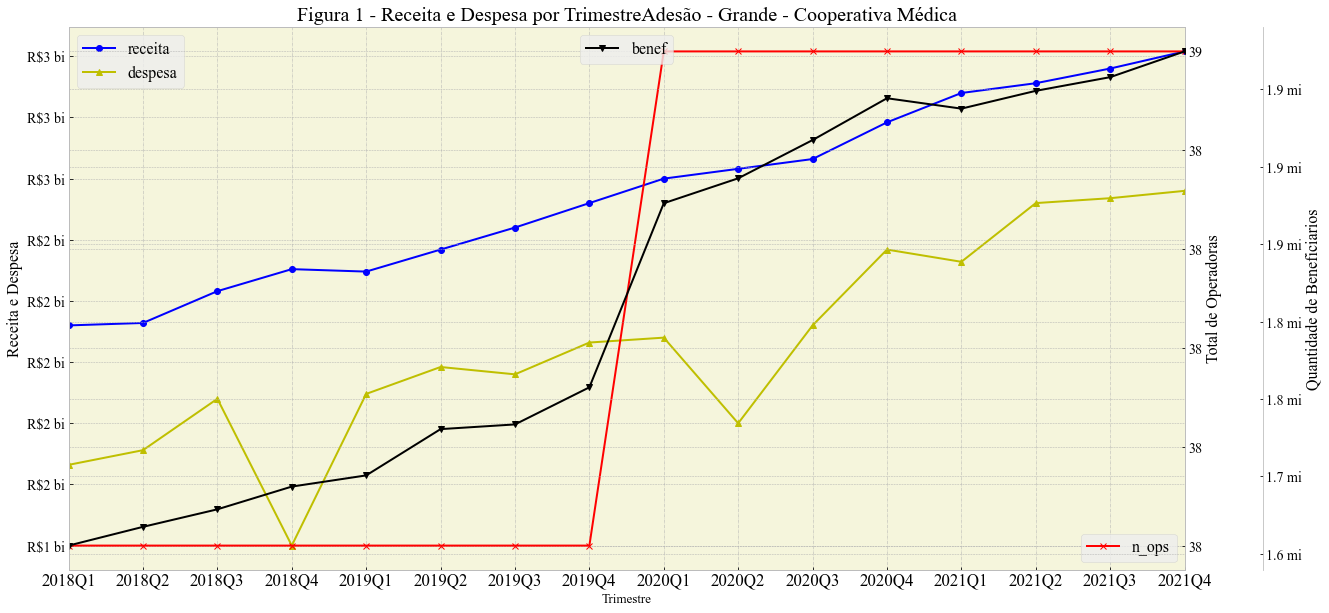

In [7]:
#Visualização geral do dados
df_plot = ans_agrup.copy()

df_plot.set_index('trimestre', inplace=True)

fig,ax1 = plt.subplots()

df_plot.plot(y=['receita','despesa'],figsize=(20, 10), style=['bo-','y^-'], ax=ax1)
ax1.set_title('Figura 1 - Receita e Despesa por Trimestre' + grupo,fontsize = 20)
ax1.set_xticks(df_plot.index)
ax1.set_xticklabels(df_plot.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita e Despesa', fontsize=16)
ax1.legend(loc = 'upper left', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_plot.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(df_plot.index)
ax2.set_xticklabels(df_plot.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
yticks = ax2.get_yticks()
ax2.set_yticklabels(yticks.astype(int), fontsize = 14)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'lower right', fontsize = 16)

ax3 = ax1.twinx()

ax3.spines.right.set_position(("axes", 1.07))

df_plot.plot(y=['benef'], figsize=(20,10), style=['kv-'], ax=ax3)
ax3.set_xticks(df_plot.index)
ax3.set_xticklabels(df_plot.index)
ax3.set_xlabel('Trimestre', fontsize = 13)
yticks = ax3.get_yticks()
ax3.set_yticklabels(['{:.1f} mi'.format(x/1e6) for x in yticks], fontsize = 14)
ax3.set_ylabel('Quantidade de Beneficiarios', fontsize=16)
ax3.legend(loc = 'upper center', fontsize = 16)

plt.show()

del df_plot

In [8]:
#Merge das duas bases (dados da ans e indicadore economicos)
ans_agrup = ans_agrup.merge(df_ind_econ, how='left', on='trimestre')

ans_agrup

,trimestre,receita,despesa,benef,n_ops,pct_despesa,ano,n_tri,n_tri_l1,benefm,benefm_diff,benefm_diff_l1,benefm_diff_l2,benefm_diff2,benefm_diff2_l1,benefm_diff2_l2,receita_l1,receita_l2,receita_diff,receita_diff_l1,receita_diff_l2,receita_diff2,receita_diff2_l1,receita_diff2_l2,despesa_l1,despesa_l2,despesa_diff,despesa_diff_l1,despesa_diff_l2,despesa_diff2,despesa_diff2_l1,despesa_diff2_l2,dmy_covid,dmy_n_ops,IPCA,Selic,Dolar,PNAD,Dolar_diff,PNAD_diff
0,2018Q1,2.150000,1.580000,1655264,38,73.490000,2018,1.000000,NaN,551754.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,0.007015,0.000158,3.245100,4285.000000,NaN,NaN
1,2018Q2,2.160000,1.640000,1667369,38,75.930000,2018,2.000000,1.000000,555789.666667,4035.000000,NaN,NaN,NaN,NaN,NaN,2.150000,NaN,0.010000,NaN,NaN,NaN,NaN,NaN,1.580000,NaN,0.060000,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,0.018887,0.000156,3.457233,4279.000000,0.212133,-6.000000
2,2018Q3,2.290000,1.850000,1678692,38,80.790000,2018,3.000000,2.000000,559564.000000,3774.333333,4035.000000,NaN,-260.666667,NaN,NaN,2.160000,2.150000,0.130000,0.010000,NaN,0.120000,NaN,NaN,1.640000,1.580000,0.210000,0.060000,NaN,0.150000,NaN,NaN,1.000000,0.000000,0.007209,0.000158,3.853900,4329.000000,0.396667,50.000000
3,2018Q4,2.380000,1.250000,1693379,38,52.520000,2018,4.000000,3.000000,564459.666667,4895.666667,3774.333333,4035.000000,1121.333333,-260.666667,NaN,2.290000,2.160000,0.090000,0.130000,0.010000,-0.040000,0.120000,NaN,1.850000,1.640000,-0.600000,0.210000,0.060000,-0.810000,0.150000,NaN,1.000000,0.000000,0.003894,0.000152,3.904500,4424.000000,0.050600,95.000000
4,2019Q1,2.370000,1.870000,1700602,38,78.900000,2019,1.000000,4.000000,566867.333333,2407.666667,4895.666667,3774.333333,-2488.000000,1121.333333,-260.666667,2.380000,2.290000,-0.010000,0.090000,0.130000,-0.100000,-0.040000,0.120000,1.250000,1.850000,0.620000,-0.600000,0.210000,1.220000,-0.810000,0.150000,1.000000,0.000000,0.015070,0.000150,3.776467,4419.000000,-0.128033,-5.000000
5,2019Q2,2.460000,1.980000,1730500,38,80.490000,2019,2.000000,1.000000,576833.333333,9966.000000,2407.666667,4895.666667,7558.333333,-2488.000000,1121.333333,2.370000,2.380000,0.090000,-0.010000,0.090000,0.100000,-0.100000,-0.040000,1.870000,1.250000,0.110000,0.620000,-0.600000,-0.510000,1.220000,-0.810000,1.000000,0.000000,0.007108,0.000153,3.903500,4327.000000,0.127033,-92.000000
6,2019Q3,2.550000,1.950000,1733529,38,76.470000,2019,3.000000,2.000000,577843.000000,1009.666667,9966.000000,2407.666667,-8956.333333,7558.333333,-2488.000000,2.460000,2.370000,0.090000,0.090000,-0.010000,0.000000,0.100000,-0.100000,1.980000,1.870000,-0.030000,0.110000,0.620000,-0.140000,-0.510000,1.220000,1.000000,0.000000,0.002601,0.000153,3.882133,4286.000000,-0.021367,-41.000000
7,2019Q4,2.650000,2.080000,1757501,38,78.490000,2019,4.000000,3.000000,585833.666667,7990.666667,1009.666667,9966.000000,6981.000000,-8956.333333,7558.333333,2.550000,2.460000,0.100000,0.090000,0.090000,0.010000,0.000000,0.100000,1.950000,1.980000,0.130000,-0.030000,0.110000,0.160000,-0.140000,-0.510000,1.000000,0.000000,0.017675,0.000123,4.131167,4410.000000,0.249034,124.000000
8,2020Q1,2.750000,2.100000,1876410,39,76.360000,2020,1.000000,4.000000,625470.000000,39636.333333,7990.666667,1009.666667,31645.666667,6981.000000,-8956.333333,2.650000,2.550000,0.100000,0.100000,0.090000,0.000000,0.010000,0.000000,2.080000,1.950000,0.020000,0.130000,-0.030000,-0.110000,0.160000,-0.140000,0.000000,1.000000,0.005308,0.000101,4.191133,4355.000000,0.059966,-55.000000
9,2020Q2,2.790000,1.750000,1892513,39,62.720000,2020,2.000000,1.000000,630837.666667,5367.666667,39636.333333,7990.666667,-34268.666667,31645.666667,6981.000000,2.750000,2.650000,0.040000,0.100000,0.100000,-0.060000,0.000000,0.010000,2.100000,2.080000,-0.350000,0.020000,0.130000,-0.370000,-0.110000,0.160000,0.000000,0.000000,-0.004306,0.000073,5.272333,4009.000000,1.081200,-346.000000


In [9]:
# reindexando o dataframe pelo campo trimestre
ans_agrup.set_index('trimestre', inplace=True)

ans_agrup_full = ans_agrup.copy()

In [10]:
ans_agrup = ans_agrup.dropna()

#informações sobre o data frame
ans_agrup.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 12 entries, 2019Q1 to 2021Q4
Freq: Q-DEC
Data columns (total 39 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   receita           12 non-null     float64
 1   despesa           12 non-null     float64
 2   benef             12 non-null     int32  
 3   n_ops             12 non-null     int32  
 4   pct_despesa       12 non-null     float64
 5   ano               12 non-null     int32  
 6   n_tri             12 non-null     float64
 7   n_tri_l1          12 non-null     float64
 8   benefm            12 non-null     float64
 9   benefm_diff       12 non-null     float64
 10  benefm_diff_l1    12 non-null     float64
 11  benefm_diff_l2    12 non-null     float64
 12  benefm_diff2      12 non-null     float64
 13  benefm_diff2_l1   12 non-null     float64
 14  benefm_diff2_l2   12 non-null     float64
 15  receita_l1        12 non-null     float64
 16  receita_l2        12 non

In [12]:
columns_receita = ['receita', 'receita_diff', 'receita_diff2', 'despesa', 'despesa_diff', 'despesa_diff2','benefm', 'benefm_diff', 'benefm_diff2']

ans_agrup

,receita,despesa,benef,n_ops,pct_despesa,ano,n_tri,n_tri_l1,benefm,benefm_diff,benefm_diff_l1,benefm_diff_l2,benefm_diff2,benefm_diff2_l1,benefm_diff2_l2,receita_l1,receita_l2,receita_diff,receita_diff_l1,receita_diff_l2,receita_diff2,receita_diff2_l1,receita_diff2_l2,despesa_l1,despesa_l2,despesa_diff,despesa_diff_l1,despesa_diff_l2,despesa_diff2,despesa_diff2_l1,despesa_diff2_l2,dmy_covid,dmy_n_ops,IPCA,Selic,Dolar,PNAD,Dolar_diff,PNAD_diff
trimestre,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019Q1,2.370000,1.870000,1700602,38,78.900000,2019,1.000000,4.000000,566867.333333,2407.666667,4895.666667,3774.333333,-2488.000000,1121.333333,-260.666667,2.380000,2.290000,-0.010000,0.090000,0.130000,-0.100000,-0.040000,0.120000,1.250000,1.850000,0.620000,-0.600000,0.210000,1.220000,-0.810000,0.150000,1.000000,0.000000,0.015070,0.000150,3.776467,4419.000000,-0.128033,-5.000000
2019Q2,2.460000,1.980000,1730500,38,80.490000,2019,2.000000,1.000000,576833.333333,9966.000000,2407.666667,4895.666667,7558.333333,-2488.000000,1121.333333,2.370000,2.380000,0.090000,-0.010000,0.090000,0.100000,-0.100000,-0.040000,1.870000,1.250000,0.110000,0.620000,-0.600000,-0.510000,1.220000,-0.810000,1.000000,0.000000,0.007108,0.000153,3.903500,4327.000000,0.127033,-92.000000
2019Q3,2.550000,1.950000,1733529,38,76.470000,2019,3.000000,2.000000,577843.000000,1009.666667,9966.000000,2407.666667,-8956.333333,7558.333333,-2488.000000,2.460000,2.370000,0.090000,0.090000,-0.010000,0.000000,0.100000,-0.100000,1.980000,1.870000,-0.030000,0.110000,0.620000,-0.140000,-0.510000,1.220000,1.000000,0.000000,0.002601,0.000153,3.882133,4286.000000,-0.021367,-41.000000
2019Q4,2.650000,2.080000,1757501,38,78.490000,2019,4.000000,3.000000,585833.666667,7990.666667,1009.666667,9966.000000,6981.000000,-8956.333333,7558.333333,2.550000,2.460000,0.100000,0.090000,0.090000,0.010000,0.000000,0.100000,1.950000,1.980000,0.130000,-0.030000,0.110000,0.160000,-0.140000,-0.510000,1.000000,0.000000,0.017675,0.000123,4.131167,4410.000000,0.249034,124.000000
2020Q1,2.750000,2.100000,1876410,39,76.360000,2020,1.000000,4.000000,625470.000000,39636.333333,7990.666667,1009.666667,31645.666667,6981.000000,-8956.333333,2.650000,2.550000,0.100000,0.100000,0.090000,0.000000,0.010000,0.000000,2.080000,1.950000,0.020000,0.130000,-0.030000,-0.110000,0.160000,-0.140000,0.000000,1.000000,0.005308,0.000101,4.191133,4355.000000,0.059966,-55.000000
2020Q2,2.790000,1.750000,1892513,39,62.720000,2020,2.000000,1.000000,630837.666667,5367.666667,39636.333333,7990.666667,-34268.666667,31645.666667,6981.000000,2.750000,2.650000,0.040000,0.100000,0.100000,-0.060000,0.000000,0.010000,2.100000,2.080000,-0.350000,0.020000,0.130000,-0.370000,-0.110000,0.160000,0.000000,0.000000,-0.004306,0.000073,5.272333,4009.000000,1.081200,-346.000000
2020Q3,2.830000,2.150000,1917215,39,75.970000,2020,3.000000,2.000000,639071.666667,8234.000000,5367.666667,39636.333333,2866.333333,-34268.666667,31645.666667,2.790000,2.750000,0.040000,0.040000,0.100000,0.000000,-0.060000,0.000000,1.750000,2.100000,0.400000,-0.350000,0.020000,0.750000,-0.370000,-0.110000,0.000000,0.000000,0.012447,0.000051,5.307533,3837.000000,0.035200,-172.000000
2020Q4,2.980000,2.460000,1944236,39,82.550000,2020,4.000000,3.000000,648078.666667,9007.000000,8234.000000,5367.666667,773.000000,2866.333333,-34268.666667,2.830000,2.790000,0.150000,0.040000,0.040000,0.110000,0.000000,-0.060000,2.150000,1.750000,0.310000,0.400000,-0.350000,-0.090000,0.750000,-0.370000,1.000000,0.000000,0.031314,0.000047,5.458467,3841.000000,0.150934,4.000000
2021Q1,3.100000,2.410000,1937524,39,77.740000,2021,1.000000,4.000000,645841.333333,-2237.333333,9007.000000,8234.000000,-11244.333333,773.000000,2866.333333,2.980000,2.830000,0.120000,0.150000,0.040000,-0.030000,0.110000,0.000000,2.460000,2.150000,-0.050000,0.310000,0.400000,-0.360000,-0.090000,0.750000,1.000000,0.000000,0.020525,0.000048,5.249900,3760.000000,-0.208567,-81.000000


receita


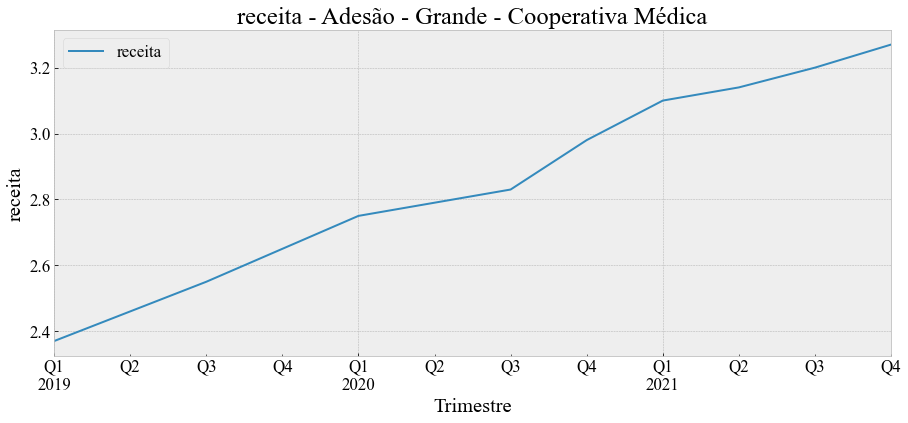

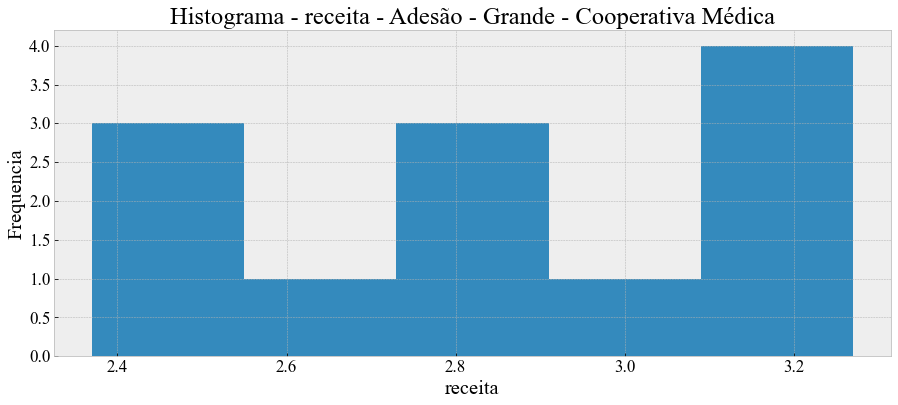

receita_diff


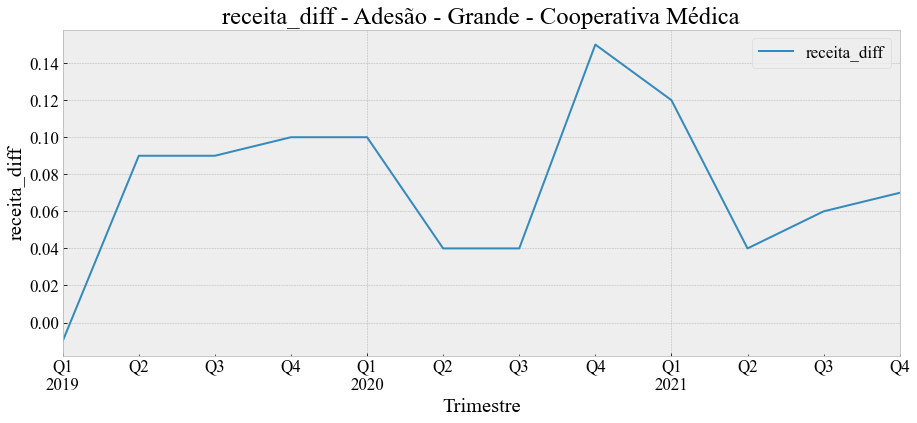

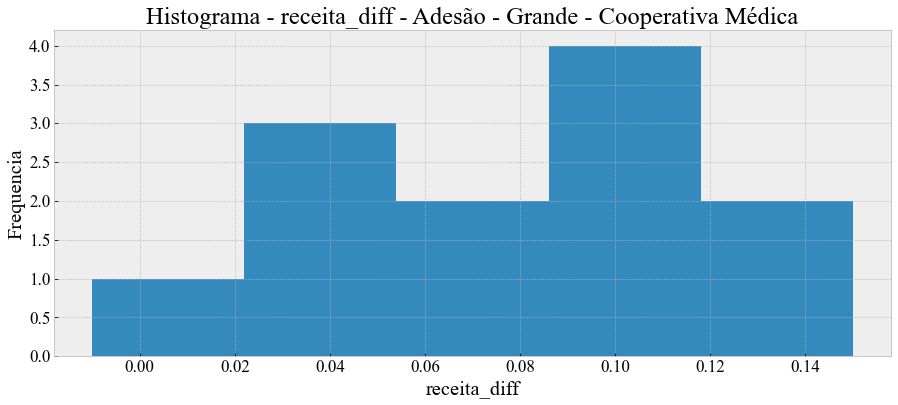

receita_diff2


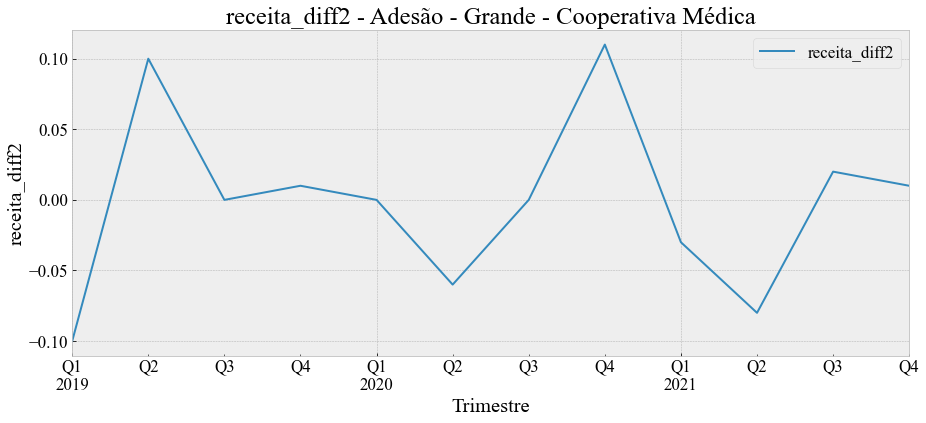

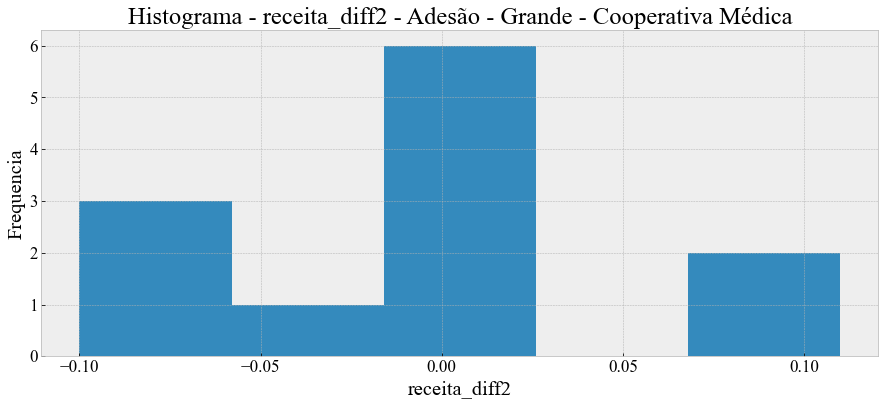

despesa


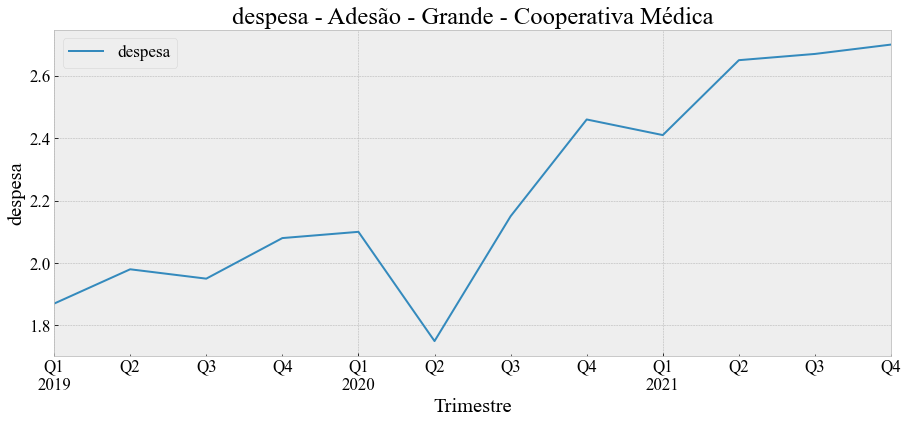

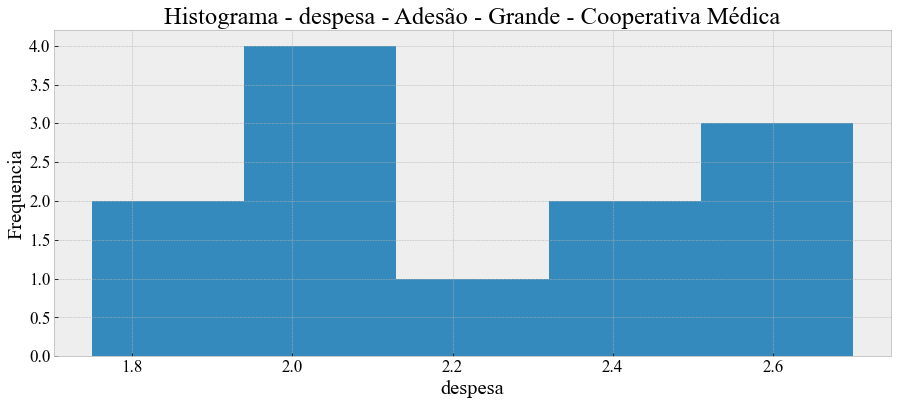

despesa_diff


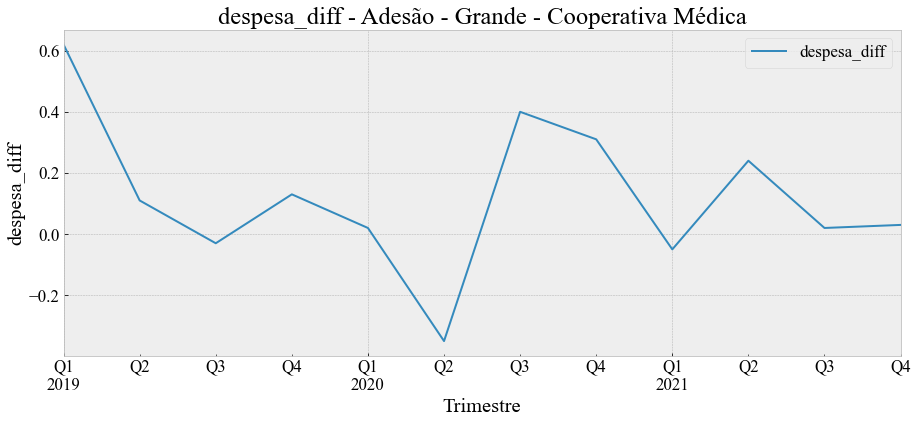

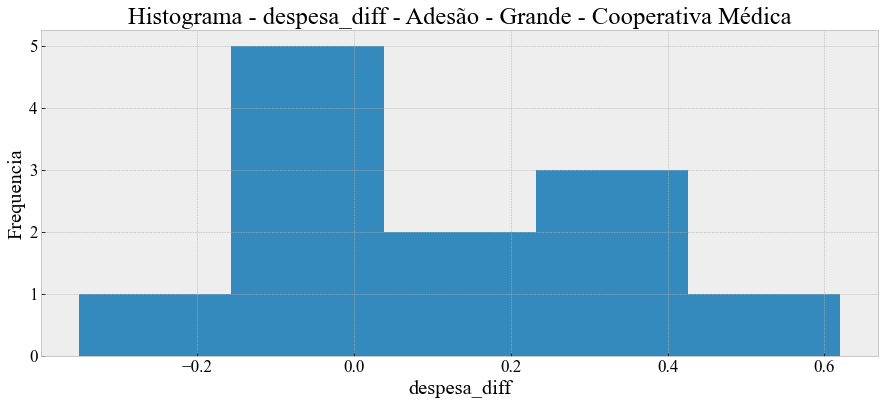

despesa_diff2


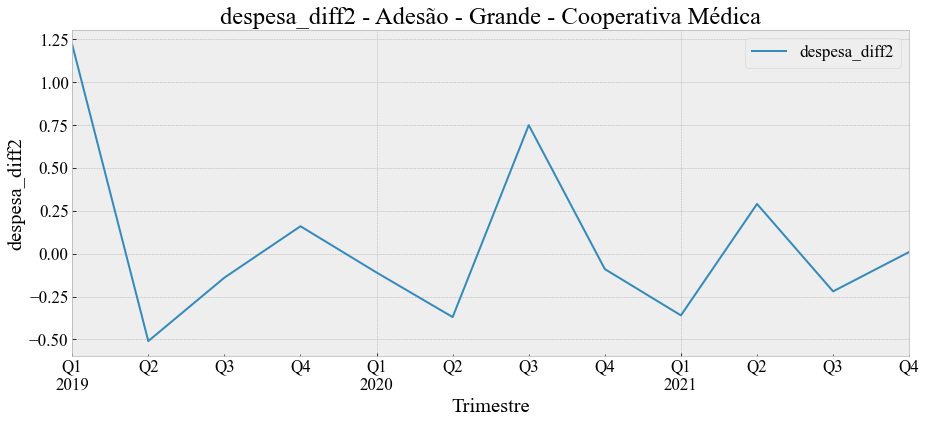

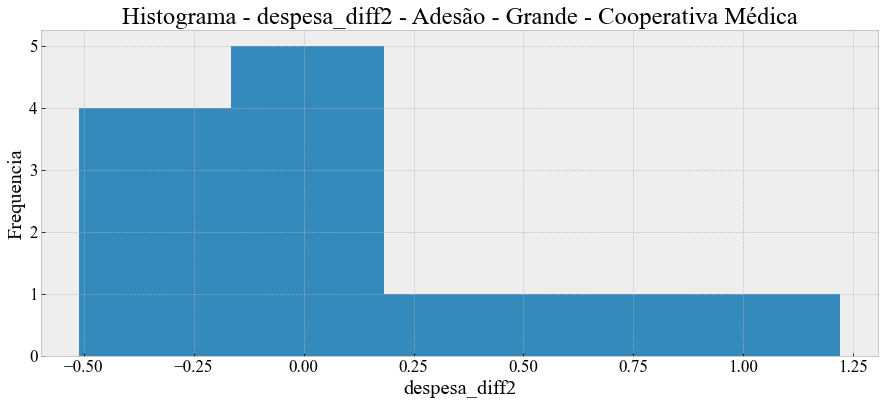

benefm


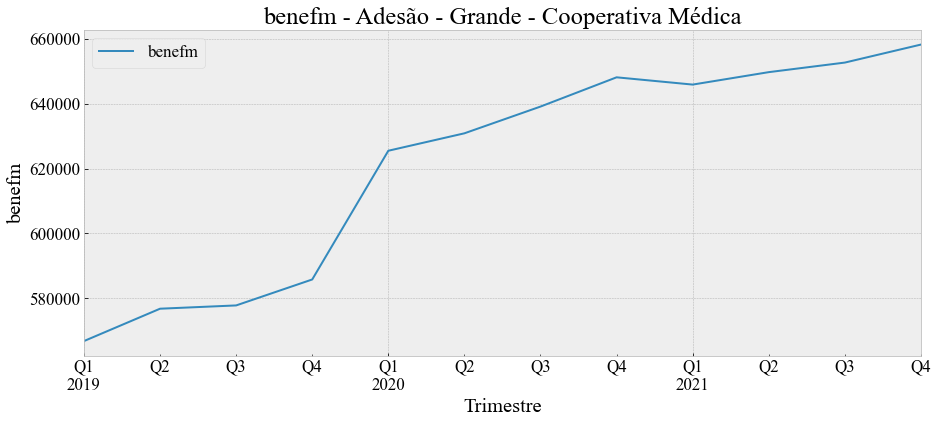

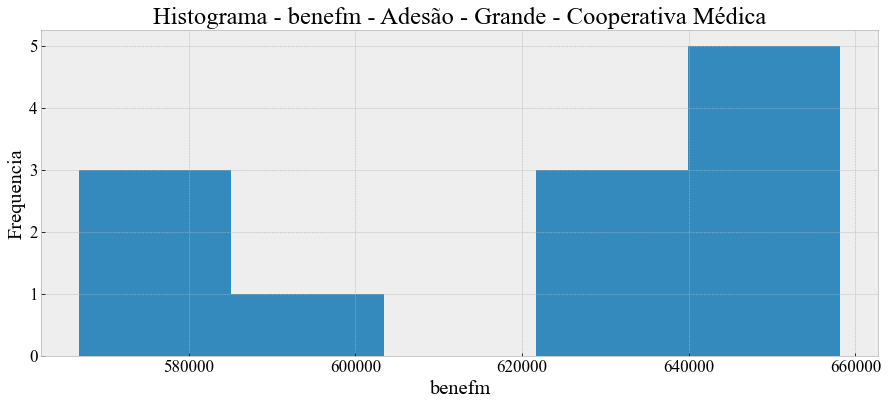

benefm_diff


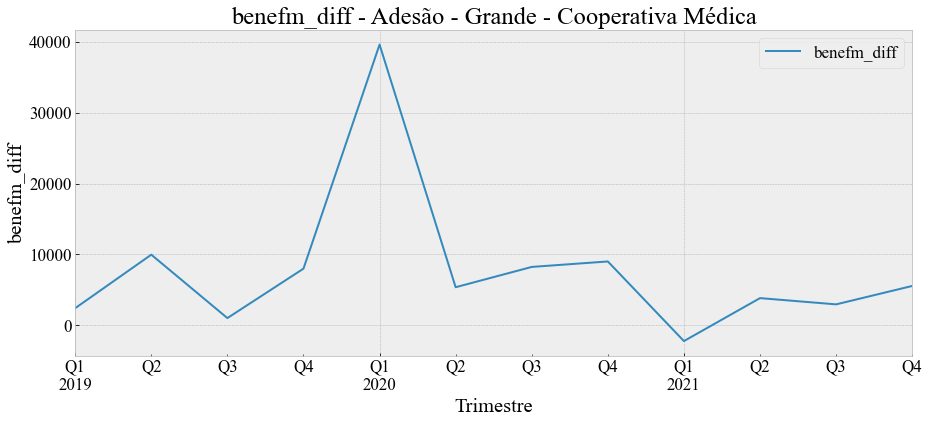

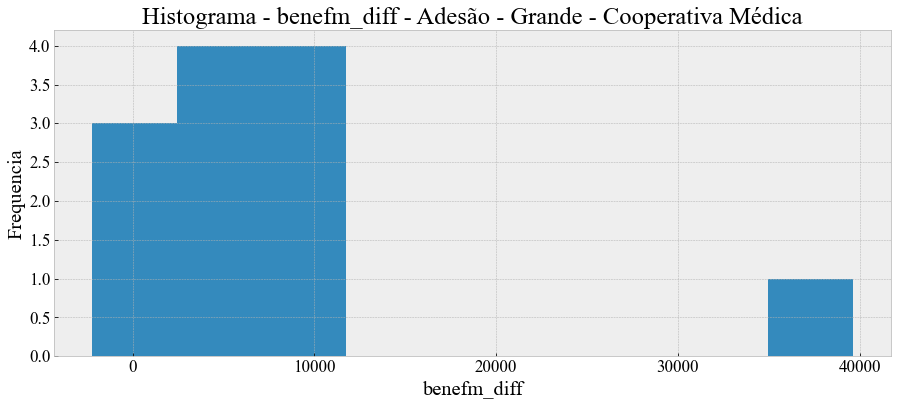

benefm_diff2


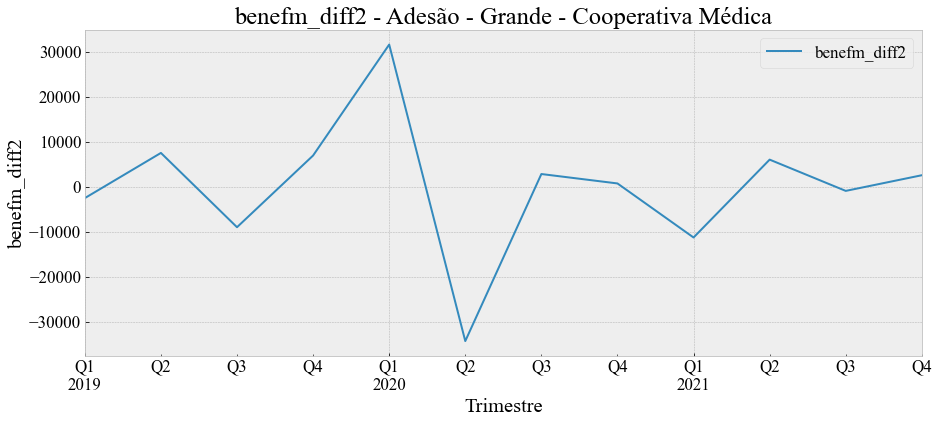

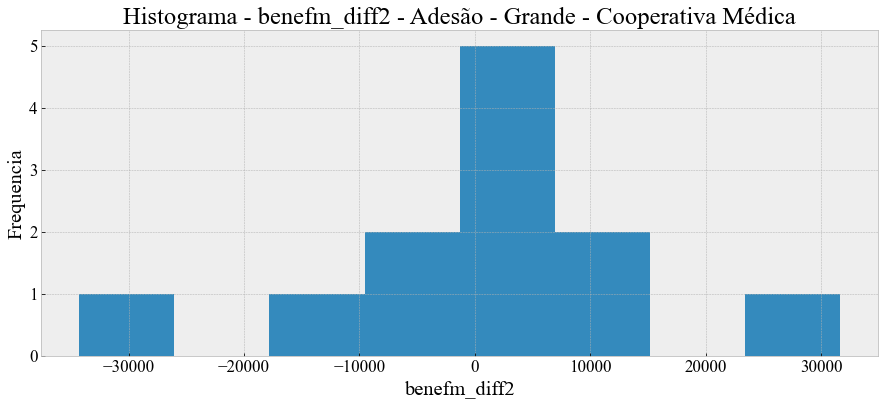

In [13]:
#Plotagem das variáveis endógenas

for c in ans_agrup[columns_receita]:
    print(str(c))

    ans_agrup.plot(y = str(c), figsize=(15,6))
    plt.xlabel('Trimestre')
    plt.ylabel(c)
    plt.title(f'{str(c)} - '+ grupo)
    plt.show()

    ans_agrup[str(c)].hist(bins='auto',figsize=(15,6))
    plt.xlabel(str(c))
    plt.ylabel('Frequencia')
    plt.title(f'Histograma - {str(c)} - '+ grupo)
    plt.show()

## 1ª Etapa -  Forecasting do Total de beneficiarios

*Variáveis exógenas*:
01. n_tri - Número do trimestre do ano
02. n_tri_l1 - Número do trimestre do ano com Lag de um período
03. benefm_diff_l1 - Primeira Diferença de beneficiario médios com lag de um período
04. benefm_diff2_l1 - Segunda Diferença de beneficiario médios com lag de um período
05. IPCA - IPCA acumulado para cada trimestre do ano
06. Selic - Taxa Selic acumulada cada trimestre do ano
07. Dolar_diff - Primeira diferenças do dolar medio para cada trimestre da ano
08. PNAD_diff - Primeira diferença do PNAD médio para cada trimestre do ano
09. dmy_covid - Variável dummy para o período de Pandemia
10. dmy_n_ops - Variável dummy para mudança de quantidade de operadoda no segmento

*Variáveis endógena*:
01. benefm_diff - Primeira Diferença de beneficiario médios

In [138]:
#Criação do dataframe com as variáveis a serem utilizadas no forecast do total de beneficiarios

ans_agrup_benefm = ans_agrup_full[['n_tri','n_tri_l1','benefm','benefm_diff','benefm_diff2','benefm_diff_l1','benefm_diff2_l1',
                                   'IPCA','Selic','Dolar','Dolar_diff','PNAD','PNAD_diff','dmy_covid','dmy_n_ops']]

ans_agrup_benefm = ans_agrup_benefm.dropna()

display(ans_agrup_benefm.info())


ans_agrup_benefm

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 13 entries, 2018Q4 to 2021Q4
Freq: Q-DEC
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   n_tri            13 non-null     float64
 1   n_tri_l1         13 non-null     float64
 2   benefm           13 non-null     float64
 3   benefm_diff      13 non-null     float64
 4   benefm_diff2     13 non-null     float64
 5   benefm_diff_l1   13 non-null     float64
 6   benefm_diff2_l1  13 non-null     float64
 7   IPCA             13 non-null     float64
 8   Selic            13 non-null     float64
 9   Dolar            13 non-null     float64
 10  Dolar_diff       13 non-null     float64
 11  PNAD             13 non-null     float64
 12  PNAD_diff        13 non-null     float64
 13  dmy_covid        13 non-null     float64
 14  dmy_n_ops        13 non-null     float64
dtypes: float64(15)
memory usage: 1.6 KB


None

,n_tri,n_tri_l1,benefm,benefm_diff,benefm_diff2,benefm_diff_l1,benefm_diff2_l1,IPCA,Selic,Dolar,Dolar_diff,PNAD,PNAD_diff,dmy_covid,dmy_n_ops
trimestre,,,,,,,,,,,,,,,
2018Q4,4.000000,3.000000,564459.666667,4895.666667,1121.333333,3774.333333,-260.666667,0.003894,0.000152,3.904500,0.050600,4424.000000,95.000000,1.000000,0.000000
2019Q1,1.000000,4.000000,566867.333333,2407.666667,-2488.000000,4895.666667,1121.333333,0.015070,0.000150,3.776467,-0.128033,4419.000000,-5.000000,1.000000,0.000000
2019Q2,2.000000,1.000000,576833.333333,9966.000000,7558.333333,2407.666667,-2488.000000,0.007108,0.000153,3.903500,0.127033,4327.000000,-92.000000,1.000000,0.000000
2019Q3,3.000000,2.000000,577843.000000,1009.666667,-8956.333333,9966.000000,7558.333333,0.002601,0.000153,3.882133,-0.021367,4286.000000,-41.000000,1.000000,0.000000
2019Q4,4.000000,3.000000,585833.666667,7990.666667,6981.000000,1009.666667,-8956.333333,0.017675,0.000123,4.131167,0.249034,4410.000000,124.000000,1.000000,0.000000
2020Q1,1.000000,4.000000,625470.000000,39636.333333,31645.666667,7990.666667,6981.000000,0.005308,0.000101,4.191133,0.059966,4355.000000,-55.000000,0.000000,1.000000
2020Q2,2.000000,1.000000,630837.666667,5367.666667,-34268.666667,39636.333333,31645.666667,-0.004306,0.000073,5.272333,1.081200,4009.000000,-346.000000,0.000000,0.000000
2020Q3,3.000000,2.000000,639071.666667,8234.000000,2866.333333,5367.666667,-34268.666667,0.012447,0.000051,5.307533,0.035200,3837.000000,-172.000000,0.000000,0.000000
2020Q4,4.000000,3.000000,648078.666667,9007.000000,773.000000,8234.000000,2866.333333,0.031314,0.000047,5.458467,0.150934,3841.000000,4.000000,1.000000,0.000000


In [139]:
#Criação dos objetos X and y 
#Variáveis Exógenas
X_benefm = ans_agrup_benefm[['n_tri','n_tri_l1','benefm_diff_l1','benefm_diff2_l1','IPCA','Selic','Dolar_diff','PNAD_diff','dmy_covid','dmy_n_ops']]

#Variáveis Endógenass
y_benefm = ans_agrup_benefm['benefm_diff']

#Verificação da estacionariedade do número beneficiarios médios
print('########################################################')
print('Teste Estacionaridade')
print('########################################################')
Augmented_Dickey_Fuller_Test_func(y_benefm, 'benefm_diff')

########################################################
Teste Estacionaridade
########################################################
Results of Dickey-Fuller Test for column benefm_diff
Test Statistic                 -3.233001
p-value                         0.018152
No Lags Used                    0.000000
Number of Observartions Used   12.000000
Critical Value (1%)            -4.137829
Critical Value (5%)            -3.154972
Critical Value (10%)           -2.714477
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


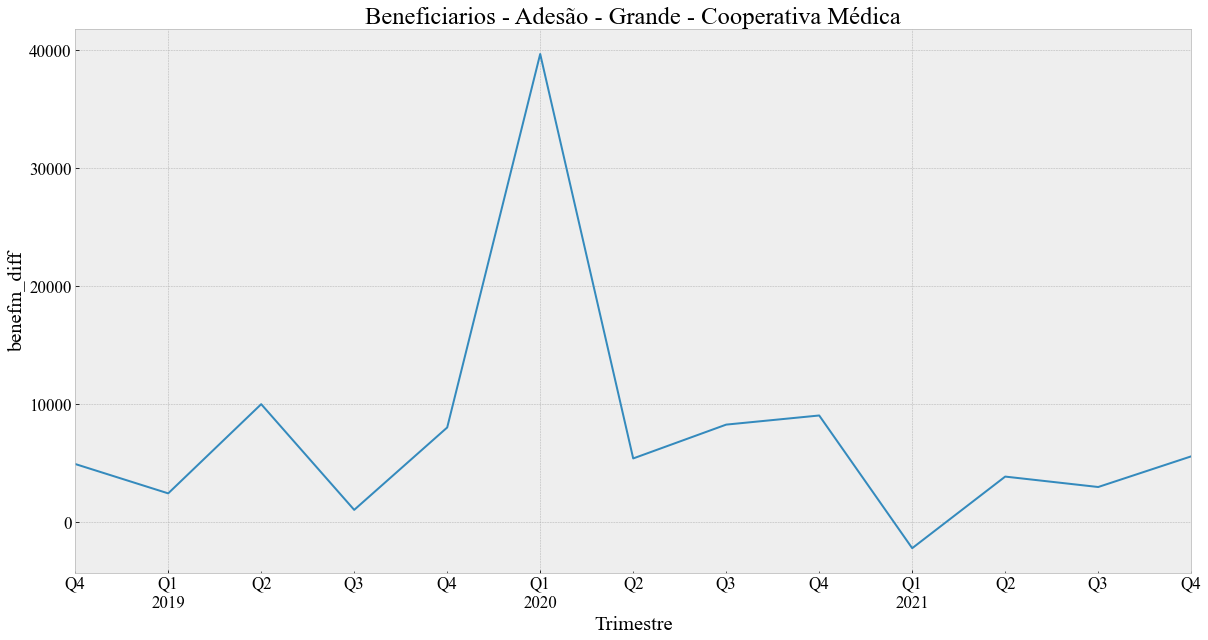

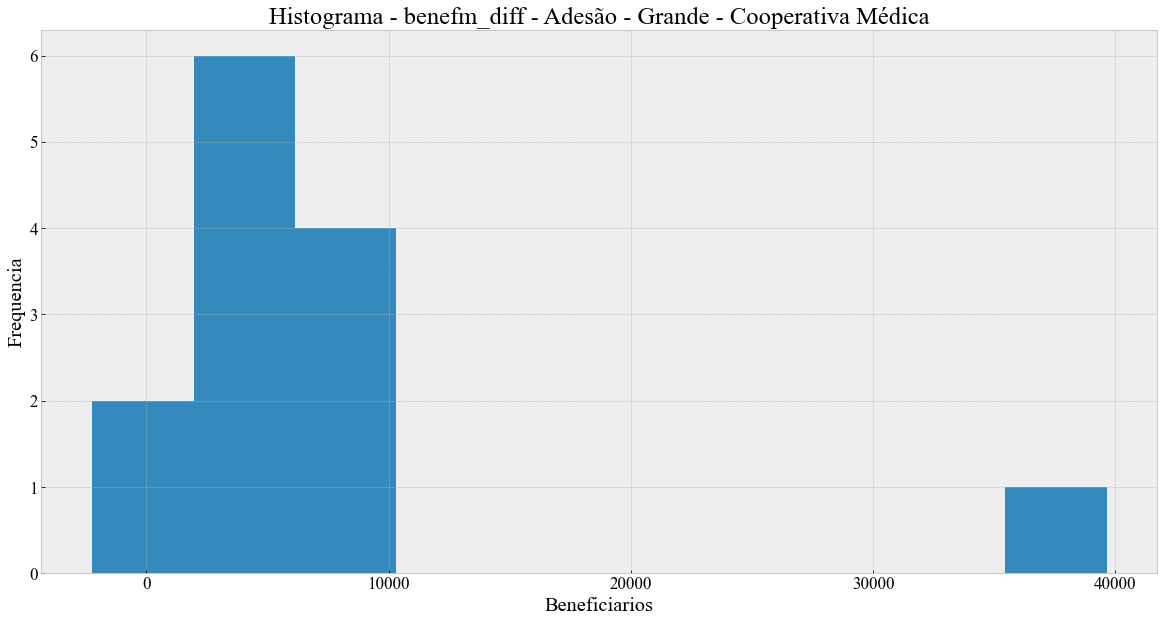

In [140]:
y_benefm.plot(y = 'Beneficiarios', figsize=(20,10))
plt.xlabel('Trimestre')
plt.ylabel('benefm_diff')
plt.title(f'Beneficiarios - '+ grupo)
plt.show()

y_benefm.hist(bins='auto',figsize=(20,10))
plt.xlabel('Beneficiarios')
plt.ylabel('Frequencia')
plt.title(f'Histograma - benefm_diff - '+ grupo)
plt.show()

In [141]:
# Criação dos dataframes com dados de treino e test
#Deixou para o Dataframe de teste os dois últimos trimestre do ano de 2021
X_benefm_train, X_benefm_test, y_benefm_train, y_benefm_test = train_test_split(X_benefm,y_benefm, test_size=2, random_state=1234, shuffle=False)

#Normalização dos dados - Todos os dados foram transformados no intervalo de 0 e 1 para o treinamento e ajustes do forecast 
scaler_X_benefm_train = preprocessing.MinMaxScaler(feature_range = (0,1))
scaler_X_benefm_train.fit(X_benefm_train)
X_benefm_train_scaled = scaler_X_benefm_train.transform(X_benefm_train)

y_benef_train_reshaped = y_benefm_train.to_numpy().reshape(-1,1)

scaler_y_benefm_train = preprocessing.MinMaxScaler(feature_range = (0,1))
scaler_y_benefm_train.fit(y_benef_train_reshaped)
y_benefm_train_scaled = scaler_y_benefm_train.transform(y_benef_train_reshaped)

In [142]:
#Inicio do treino
#Para encontrar os melhores hiper parametros para o treinamento do Xgbosot regressor, utilizou se BayesSearchCV como método de busca otimizada
xg_regr_benefm_bayes = BayesSearchCV( XGBRegressor(),
                                   {'learning_rate': (10e-6, 1.0,'log-uniform'),
                                   'n_estimators': (10,1000,'log-uniform'),
                                   'max_depth': Integer(0, 50,'uniform')},
                                    n_iter=10,                                    
                                    n_jobs=-1,
                                    verbose=True)

#Bayesian
xg_regr_benefm_bayes.fit(X_benefm_train_scaled,y_benefm_train_scaled)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


BayesSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     r

In [143]:
X_benefm_test_scaled = scaler_X_benefm_train.transform(X_benefm_test)

y_benefm_pred_scaled = xg_regr_benefm_bayes.predict(X_benefm_test_scaled)
y_benefm_pred = scaler_y_benefm_train.inverse_transform(y_benefm_pred_scaled.reshape(-1,1))
y_benefm_pred = y_benefm_pred.reshape(-1)

best_params_benefm = xg_regr_benefm_bayes.best_params_

print('Best Hyper parameters - Benefm_diff')
print(xg_regr_benefm_bayes.best_params_)

Best Hyper parameters - Benefm_diff
OrderedDict([('learning_rate', 0.415985138723616), ('max_depth', 25), ('n_estimators', 44)])


In [144]:
print('########################################################')
print('Métricas do erro - Benefm_diff -  Para o dados de Teste')
print('########################################################')
timeseries_evaluation_metrics_func(list(y_benefm_test),list(y_benefm_pred))

########################################################
Métricas do erro - Benefm_diff -  Para o dados de Teste
########################################################
Mean_Squared_Error_(MSE) is : 21431823.825904403
Root_Mean_Squared_Error_(RMSE) is : 4629.451784596574
Mean_Absolute_Error_(MAE) is : 4082.424540201784
Mean_Absolute_Percentage_Error (MAPE) is : 0.8872255843217973
Symmetrical_Mean_Absolute_Percentage_Error (sMAPE) is : 0.8365621586543135
Coefficient of determination R^2 is : -11.694569292295249



,metrics,scores
0,MSE,21431823.825904
1,RMSE,4629.451785
2,MAE,4082.424540
3,MAPE,0.887226
4,sMAPE,0.836562
5,R^2,-11.694569


In [145]:
#Criação do dataframe com "importances" de cada variável exógena
fi_benefm = pd.DataFrame( {'features': X_benefm_train.columns,
                           'importance': xg_regr_benefm_bayes.best_estimator_.feature_importances_})

fi_benefm = fi_benefm.sort_values('importance', ascending=False)

fi_benefm

,features,importance
9,dmy_n_ops,0.908782
6,Dolar_diff,0.034078
5,Selic,0.032851
7,PNAD_diff,0.014075
3,benefm_diff2_l1,0.005175
4,IPCA,0.003944
2,benefm_diff_l1,0.000584
1,n_tri_l1,0.000297
0,n_tri,0.000214
8,dmy_covid,0.000000


In [146]:
#Valores estimados de benefm_diff para o período de treino
df_benefm_diff_pred = pd.DataFrame(y_benefm_pred, columns=['benefm_diff'])
df_benefm_diff_pred

,benefm_diff
0,1047.275269
1,11810.791016


In [147]:
actual_df = pd.DataFrame(ans_agrup['benefm'].iloc[:-3])

display(actual_df)

df_benefm_pred = df_benefm_diff_pred.rename({'benefm_diff': 'benefm'}, axis = 1)

res_benefm = inverse_diff(actual_df,df_benefm_pred)

res_benefm = res_benefm.rename({'benefm': 'benefm_diff'}, axis = 1)

res_benefm

,benefm
trimestre,
2019Q1,566867.333333
2019Q2,576833.333333
2019Q3,577843.000000
2019Q4,585833.666667
2020Q1,625470.000000
2020Q2,630837.666667
2020Q3,639071.666667
2020Q4,648078.666667
2021Q1,645841.333333


,benefm_diff,benefm_1st_inv_diff
0,1047.275269,646888.562500
1,11810.791016,658699.375000


In [148]:
print('########################################################')
print('Métricas do erro - Benefm -  Para o dados de Teste')
print('########################################################')
df_evaluation_metrics_benefm = timeseries_evaluation_metrics_func(list(ans_agrup['benefm'].iloc[-2:]),list(res_benefm['benefm_1st_inv_diff']))

df_evaluation_metrics_benefm.to_csv('xgboost_errors_metrics_benefm_bayes'+ grupo +'.csv',  sep=';', index=False, encoding='mbcs', decimal=',')

########################################################
Métricas do erro - Benefm -  Para o dados de Teste
########################################################
Mean_Squared_Error_(MSE) is : 16555166.346570957
Root_Mean_Squared_Error_(RMSE) is : 4068.8040437665413
Mean_Absolute_Error_(MAE) is : 3132.739583333314
Mean_Absolute_Percentage_Error (MAPE) is : 0.004796805445511388
Symmetrical_Mean_Absolute_Percentage_Error (sMAPE) is : 0.004815990600538235
Coefficient of determination R^2 is : -1.153467026394734



In [149]:
df_benefm_test = pd.DataFrame(ans_agrup['benefm'].iloc[-2:])

df_benefm_test['benefm_pred'] = res_benefm['benefm_1st_inv_diff'].to_numpy()

df_benefm_test

,benefm,benefm_pred
trimestre,,
2021Q3,652617.666667,646888.562500
2021Q4,658163.000000,658699.375000


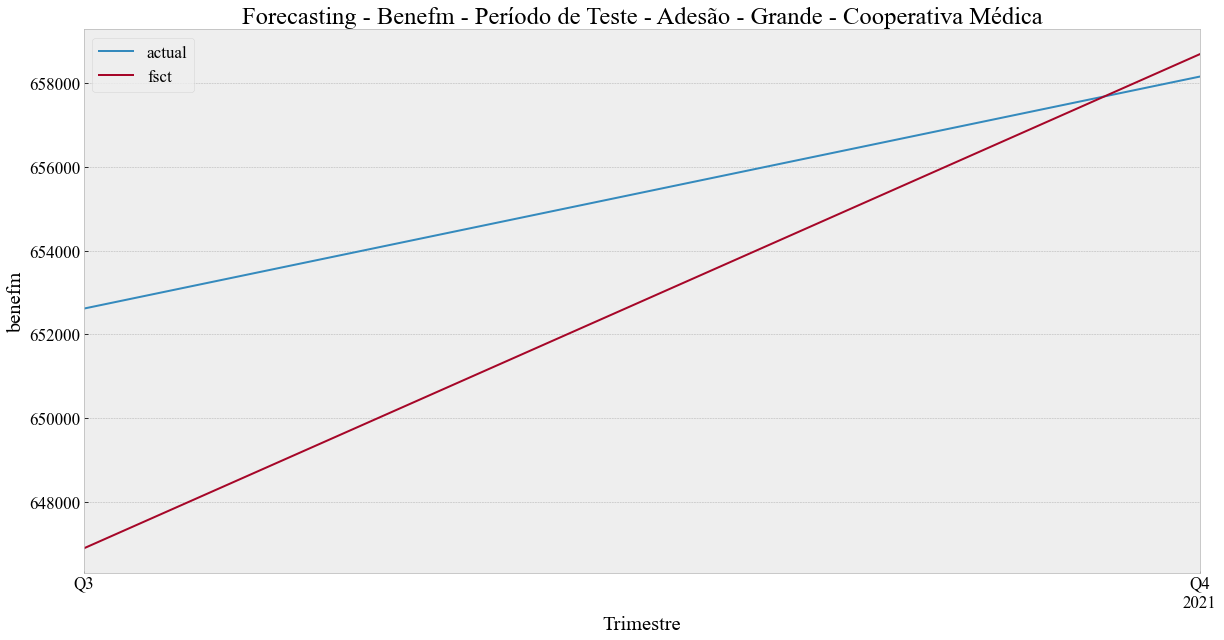

In [150]:
#Plotagem da predição e dados de testes
df_benefm_test.plot(figsize=(20,10))
plt.legend(['actual','fsct'])
plt.title(f'Forecasting - Benefm - Período de Teste - '+ grupo)
plt.ylabel('benefm')
plt.xlabel('Trimestre')
plt.show()

In [151]:
#Retreinando random forest com os dados completos
#Normalização dos dados
scaler_X_benefm_train = preprocessing.MinMaxScaler(feature_range = (0,1))
scaler_X_benefm_train.fit(X_benefm)
X_benefm_scaled = scaler_X_benefm_train.transform(X_benefm)

y_benef_reshaped = y_benefm.to_numpy().reshape(-1,1)

scaler_y_benefm = preprocessing.MinMaxScaler(feature_range = (0,1))
scaler_y_benefm.fit(y_benef_reshaped)
y_benefm_scaled = scaler_y_benefm.transform(y_benef_reshaped)

In [152]:
xg_regr_benefm = XGBRegressor(max_depth=best_params_benefm['max_depth'],
                              n_estimators=best_params_benefm['n_estimators'],
                              learning_rate = best_params_benefm['learning_rate'])

xg_regr_benefm.fit(X_benefm_scaled,y_benefm_scaled)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.415985138723616, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=25, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=44, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [153]:
#Criação do dataframe teste para os 3 próximos anos - Cenário economico

benefm_diff1_l1_list = [y_benefm.iloc[-1]]
benefm_diff1_l1_list_temp = [np.nan]*11
benefm_diff1_l1_list.extend(benefm_diff1_l1_list_temp)

benefm_diff2_l1_list = [ans_agrup_benefm['benefm_diff2'].iloc[-1]]
benefm_diff2_l1_list_temp = [np.nan]*11
benefm_diff2_l1_list.extend(benefm_diff2_l1_list_temp)

ipca_list = [0.032007, 0.02215]
ipca_list_temp = [0.03]*10
ipca_list.extend(ipca_list_temp)

selic_list = [0.000242, 0.000288]
selic_list_temp = [0.0002]*10
selic_list.extend(selic_list_temp)

dolar_list = np.array([ans_agrup_full['Dolar'].iloc[-1], 5.478567, 4.9849, 5.51, 5.65, 5.545, 5.85, 5.90, 6.05, 6.10, 6.15, 6.30, 6.40])
dolar_diff_list = np.diff(dolar_list)

pnad_list = [0.191, 0.140]
pnad_list_temp = [0.120]*10
pnad_list.extend(pnad_list_temp)

input = {'n_tri': [1,2,3,4, 1,2,3,4, 1,2,3,4],
         'n_tri_l1': [4, 1,2,3,4, 1,2,3,4,1,2,3],         
         'benefm_diff_l1':  benefm_diff1_l1_list,
         'benefm_diff2_l1': benefm_diff2_l1_list,         
         'IPCA': ipca_list,
         'Selic': selic_list,
         'Dolar_diff': dolar_diff_list,
         'PNAD_diff': pnad_list, 
         'dmy_covid': [1.0]*12,
         'dmy_n_ops': [0.0]*12}

index_df_pred_test = [  '2022Q1',
                        '2022Q2',
                        '2022Q3',
                        '2022Q4',
                        '2023Q1',
                        '2023Q2',
                        '2023Q3',
                        '2023Q4',
                        '2024Q1',
                        '2024Q2',
                        '2024Q3',
                        '2024Q4']

df_benef_pred_test = pd.DataFrame(input, index = index_df_pred_test)

#Dataframe com os valores para predição dos próximos anos
df_benef_pred_test

,n_tri,n_tri_l1,benefm_diff_l1,benefm_diff2_l1,IPCA,Selic,Dolar_diff,PNAD_diff,dmy_covid,dmy_n_ops
2022Q1,1,4,5545.333333,2598.666667,0.032007,0.000242,0.102400,0.191000,1.000000,0.000000
2022Q2,2,1,NaN,NaN,0.022150,0.000288,-0.493667,0.140000,1.000000,0.000000
2022Q3,3,2,NaN,NaN,0.030000,0.000200,0.525100,0.120000,1.000000,0.000000
2022Q4,4,3,NaN,NaN,0.030000,0.000200,0.140000,0.120000,1.000000,0.000000
2023Q1,1,4,NaN,NaN,0.030000,0.000200,-0.105000,0.120000,1.000000,0.000000
2023Q2,2,1,NaN,NaN,0.030000,0.000200,0.305000,0.120000,1.000000,0.000000
2023Q3,3,2,NaN,NaN,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000
2023Q4,4,3,NaN,NaN,0.030000,0.000200,0.150000,0.120000,1.000000,0.000000
2024Q1,1,4,NaN,NaN,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000
2024Q2,2,1,NaN,NaN,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000


In [154]:
y_pred_list = []

for i in range(len(df_benef_pred_test)):
    #X_test = df_pred_test.iloc[i:i+1]
    X_benefm_test = df_benef_pred_test.iloc[:i+1]
    X_benefm_test_scaled_pred = scaler_X_benefm_train.transform(X_benefm_test)

    y_benefm_pred_scaled = xg_regr_benefm.predict(X_benefm_test_scaled_pred)
    
    y_benefm_pred = scaler_y_benefm_train.inverse_transform(y_benefm_pred_scaled.reshape(-1,1))
    y_benefm_pred = y_benefm_pred.reshape(-1)

    #print(y_pred)
    #y_pred_list.append(y_pred)

    if i < len(df_benef_pred_test)-1:
        df_benef_pred_test['benefm_diff_l1'].iloc[i+1] = y_benefm_pred[-1]
        df_benef_pred_test['benefm_diff2_l1'].iloc[i+1] = y_benefm_pred[-1] - df_benef_pred_test['benefm_diff_l1'].iloc[i:i+1]

#Dataframe opós as predições realizadas na célula anterior
display(df_benef_pred_test)

,n_tri,n_tri_l1,benefm_diff_l1,benefm_diff2_l1,IPCA,Selic,Dolar_diff,PNAD_diff,dmy_covid,dmy_n_ops
2022Q1,1,4,5545.333333,2598.666667,0.032007,0.000242,0.102400,0.191000,1.000000,0.000000
2022Q2,2,1,9198.369141,3653.035807,0.022150,0.000288,-0.493667,0.140000,1.000000,0.000000
2022Q3,3,2,1433.708740,-7764.660400,0.030000,0.000200,0.525100,0.120000,1.000000,0.000000
2022Q4,4,3,7434.059570,6000.350830,0.030000,0.000200,0.140000,0.120000,1.000000,0.000000
2023Q1,1,4,4010.755371,-3423.304199,0.030000,0.000200,-0.105000,0.120000,1.000000,0.000000
2023Q2,2,1,4566.497559,555.742188,0.030000,0.000200,0.305000,0.120000,1.000000,0.000000
2023Q3,3,2,4221.722656,-344.774902,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000
2023Q4,4,3,3974.568848,-247.153809,0.030000,0.000200,0.150000,0.120000,1.000000,0.000000
2024Q1,1,4,4010.755371,36.186523,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000
2024Q2,2,1,4257.908691,247.153320,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000


In [155]:
#Predição para benefm_diff para os próximos 3 anos
df_benefm_diff_pred = pd.DataFrame(y_benefm_pred, columns=['benefm_diff_pred'], index = index_df_pred_test)
df_benefm_diff_pred

,benefm_diff_pred
2022Q1,9198.369141
2022Q2,1433.708740
2022Q3,7434.059570
2022Q4,4010.755371
2023Q1,4566.497559
2023Q2,4221.722656
2023Q3,3974.568848
2023Q4,4010.755371
2024Q1,4257.908691
2024Q2,4221.722656


In [156]:
actual_df = pd.DataFrame(ans_agrup_benefm['benefm'])

df_benefm_pred = df_benefm_diff_pred.rename({'benefm_diff_pred': 'benefm'}, axis = 1)

pred_res = inverse_diff(actual_df,df_benefm_pred)

pred_res.rename({'benefm_1st_inv_diff': 'benefm_pred'}, axis=1, inplace=True)

def_benefm_pred = pd.DataFrame(pred_res['benefm_pred'])

def_benefm_pred

,benefm_pred
2022Q1,667361.375000
2022Q2,668795.062500
2022Q3,676229.125000
2022Q4,680239.875000
2023Q1,684806.375000
2023Q2,689028.125000
2023Q3,693002.687500
2023Q4,697013.437500
2024Q1,701271.375000
2024Q2,705493.062500


In [157]:
#Criação com os valores reais e estimados pelo modelo
ans_agrup_temp = pd.DataFrame(ans_agrup_full['benefm'])
ans_agrup_benefm_join = ans_agrup_temp.append(pd.DataFrame(def_benefm_pred['benefm_pred']))
ans_agrup_benefm_join

,benefm,benefm_pred
2018Q1,551754.666667,NaN
2018Q2,555789.666667,NaN
2018Q3,559564.000000,NaN
2018Q4,564459.666667,NaN
2019Q1,566867.333333,NaN
2019Q2,576833.333333,NaN
2019Q3,577843.000000,NaN
2019Q4,585833.666667,NaN
2020Q1,625470.000000,NaN
2020Q2,630837.666667,NaN


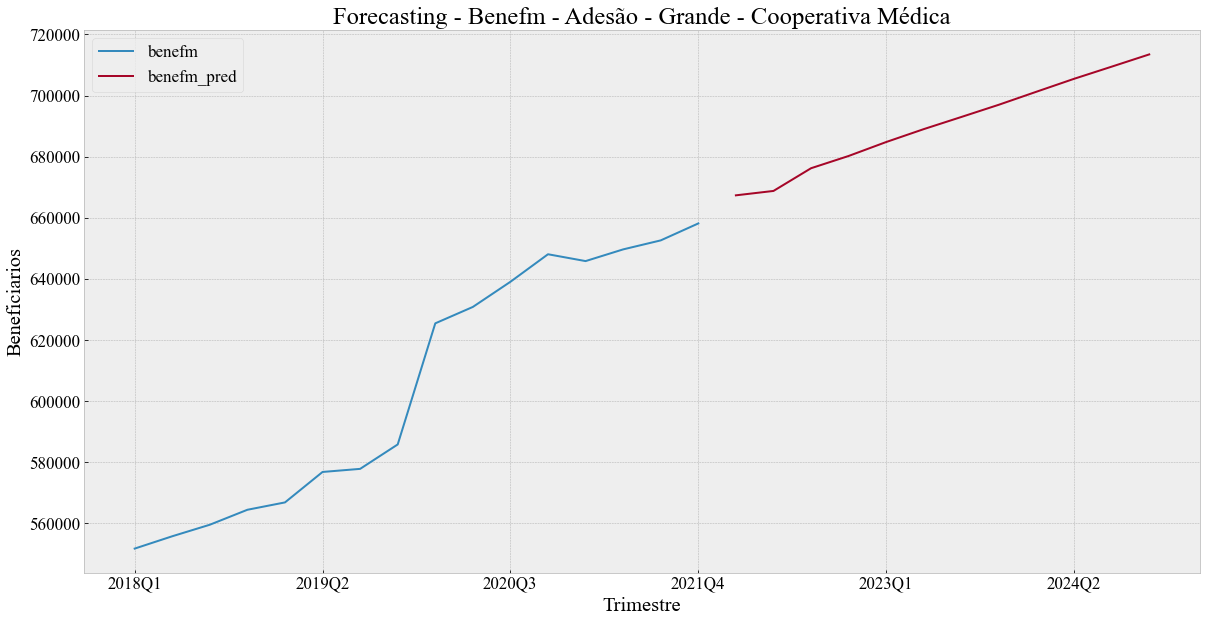

In [158]:
ans_agrup_benefm_join.plot(figsize=(20,10))
plt.legend(['benefm','benefm_pred'])
plt.title(f'Forecasting - Benefm - '+ grupo)
plt.ylabel('Beneficiarios')
plt.xlabel('Trimestre')
plt.show()

## 2ª Etapa -  Forecasting da Receita

*Variáveis exógenas*:
01. n_tri - Número do trimestre do ano
02. n_tri_l1 - Número do trimestre do ano com Lag de um período
03. benefm_diff - Primeira Diferença de beneficiario médios estimados na etapa anteriror
04. receita_diff_l1 - Primeira Diferença da receita com lag de um período
05. receita_diff2_l1 - Segunda Diferença da receita com lag de um período
06. IPCA - IPCA acumulado para cada trimestre do ano
07. Selic - Taxa Selic acumulada cada trimestre do ano
08. Dolar_diff - Primeira diferenças do dolar medio para cada trimestre da ano
09. PNAD_diff - Primeira diferença do PNAD médio para cada trimestre do ano
10. dmy_covid - Variável dummy para o período de Pandemia
11. dmy_n_ops - Variável dummy para mudança de quantidade de operadoda no segmento

*Variáveis endógena*:
01. receita_diff - Primeira Diferença das receitas trimestrais

In [159]:
#Criação do dataframe com as variáveis a serem utilizadas no forecasting das receitas trimestrais

ans_agrup_rec = ans_agrup_full[['n_tri','n_tri_l1','receita','receita_diff','receita_diff2','receita_diff_l1','receita_diff2_l1',
                                'benefm_diff','IPCA','Selic','Dolar','Dolar_diff','PNAD','PNAD_diff','dmy_covid','dmy_n_ops']]

ans_agrup_rec = ans_agrup_rec.dropna()

ans_agrup_rec

,n_tri,n_tri_l1,receita,receita_diff,receita_diff2,receita_diff_l1,receita_diff2_l1,benefm_diff,IPCA,Selic,Dolar,Dolar_diff,PNAD,PNAD_diff,dmy_covid,dmy_n_ops
trimestre,,,,,,,,,,,,,,,,
2018Q4,4.000000,3.000000,2.380000,0.090000,-0.040000,0.130000,0.120000,4895.666667,0.003894,0.000152,3.904500,0.050600,4424.000000,95.000000,1.000000,0.000000
2019Q1,1.000000,4.000000,2.370000,-0.010000,-0.100000,0.090000,-0.040000,2407.666667,0.015070,0.000150,3.776467,-0.128033,4419.000000,-5.000000,1.000000,0.000000
2019Q2,2.000000,1.000000,2.460000,0.090000,0.100000,-0.010000,-0.100000,9966.000000,0.007108,0.000153,3.903500,0.127033,4327.000000,-92.000000,1.000000,0.000000
2019Q3,3.000000,2.000000,2.550000,0.090000,0.000000,0.090000,0.100000,1009.666667,0.002601,0.000153,3.882133,-0.021367,4286.000000,-41.000000,1.000000,0.000000
2019Q4,4.000000,3.000000,2.650000,0.100000,0.010000,0.090000,0.000000,7990.666667,0.017675,0.000123,4.131167,0.249034,4410.000000,124.000000,1.000000,0.000000
2020Q1,1.000000,4.000000,2.750000,0.100000,0.000000,0.100000,0.010000,39636.333333,0.005308,0.000101,4.191133,0.059966,4355.000000,-55.000000,0.000000,1.000000
2020Q2,2.000000,1.000000,2.790000,0.040000,-0.060000,0.100000,0.000000,5367.666667,-0.004306,0.000073,5.272333,1.081200,4009.000000,-346.000000,0.000000,0.000000
2020Q3,3.000000,2.000000,2.830000,0.040000,0.000000,0.040000,-0.060000,8234.000000,0.012447,0.000051,5.307533,0.035200,3837.000000,-172.000000,0.000000,0.000000
2020Q4,4.000000,3.000000,2.980000,0.150000,0.110000,0.040000,0.000000,9007.000000,0.031314,0.000047,5.458467,0.150934,3841.000000,4.000000,1.000000,0.000000


In [160]:
#Criação dos objetos X and y 
#Variáveis Exógenas
X_rec = ans_agrup_rec[['n_tri','n_tri_l1','receita_diff_l1','receita_diff2_l1','benefm_diff','IPCA','Selic','Dolar_diff','PNAD_diff','dmy_covid','dmy_n_ops']]

#Variável Endógena
y_rec = ans_agrup_rec['receita_diff']

#Verificação da estacionariedade da receita
print('#########################################################################')
print('Teste Estacionaridade - Receita_diff')
print('#########################################################################')
Augmented_Dickey_Fuller_Test_func(y_rec, 'receita_diff')

#########################################################################
Teste Estacionaridade - Receita_diff
#########################################################################
Results of Dickey-Fuller Test for column receita_diff
Test Statistic                 -5.206978
p-value                         0.000009
No Lags Used                    3.000000
Number of Observartions Used    9.000000
Critical Value (1%)            -4.473135
Critical Value (5%)            -3.289881
Critical Value (10%)           -2.772382
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


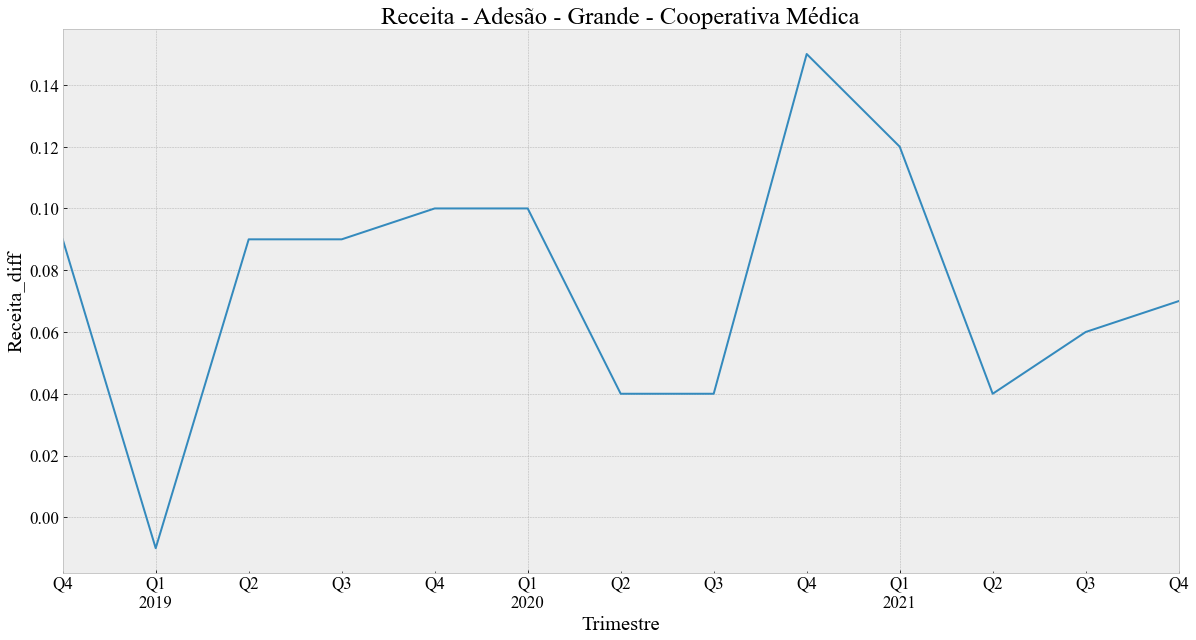

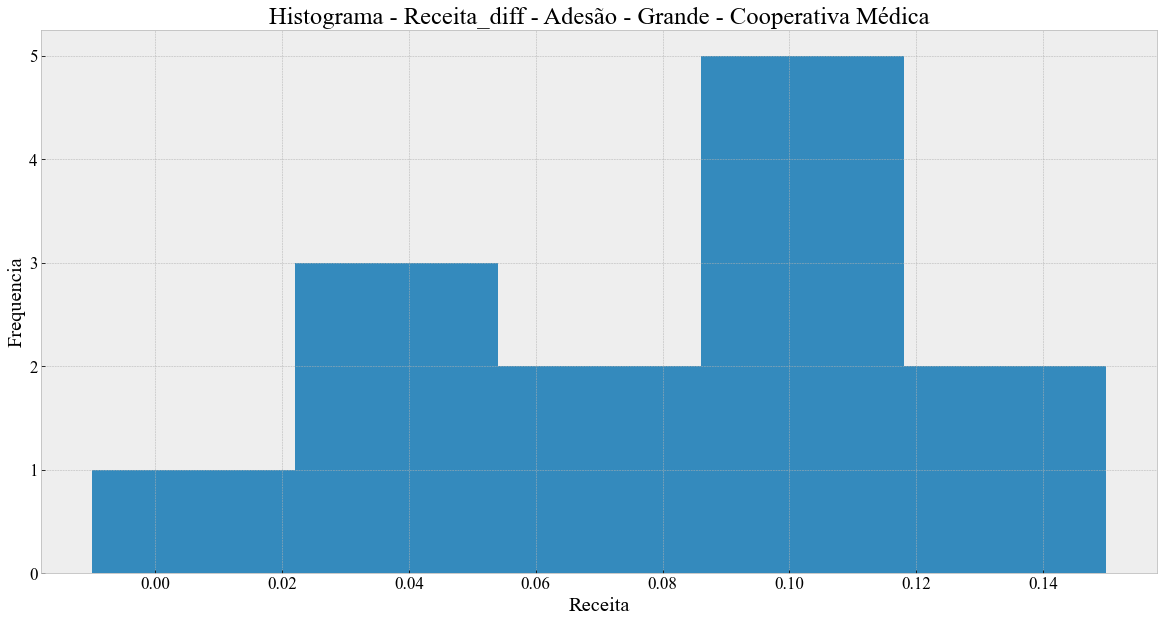

In [161]:
y_rec.plot(y = 'Receita', figsize=(20,10))
plt.xlabel('Trimestre')
plt.ylabel('Receita_diff')
plt.title(f'Receita - '+ grupo)
plt.show()

y_rec.hist(bins='auto',figsize=(20,10))
plt.xlabel('Receita')
plt.ylabel('Frequencia')
plt.title(f'Histograma - Receita_diff - '+ grupo)
plt.show()

In [162]:
# Criação dos dataframes com dados de treino e test
#Deixou para o Dataframe de teste os dois últimos trimestre do ano de 2021
X_rec_train, X_rec_test, y_rec_train, y_rec_test = train_test_split(X_rec,y_rec, test_size=2, random_state=1234, shuffle=False)

#Normalização dos dados - Todos os dados foram transformados no intervalo de 0 e 1 para o treinamento e ajustes do forecast 
scaler_X_rec_train = preprocessing.MinMaxScaler(feature_range = (0,1))
scaler_X_rec_train.fit(X_rec_train)
X_rec_train_scaled = scaler_X_rec_train.transform(X_rec_train)

y_rec_train_reshaped = y_rec_train.to_numpy().reshape(-1,1)

scaler_y_rec_train = preprocessing.MinMaxScaler(feature_range = (0,1))
scaler_y_rec_train.fit(y_rec_train_reshaped)
y_rec_train_scaled = scaler_y_rec_train.transform(y_rec_train_reshaped)

In [163]:
#Inicio do treino
#Para encontrar os melhores hiper parametros para o treinamento do Xgbosot regressor, utilizou se BayesSearchCV como método de busca otimizada
xg_regr_rec_bayes = BayesSearchCV( XGBRegressor(),
                                   {'learning_rate': (10e-6, 1.0,'log-uniform'),
                                   'n_estimators': (10,1000,'log-uniform'),
                                   'max_depth': Integer(0, 50,'uniform')},
                                    n_iter=10,                                    
                                    n_jobs=-1,
                                    verbose=True)

#Bayesian
xg_regr_rec_bayes.fit(X_rec_train_scaled,y_rec_train_scaled)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


BayesSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     r

In [164]:
X_rec_test_scaled = scaler_X_rec_train.transform(X_rec_test)

y_rec_pred = xg_regr_rec_bayes.predict(X_rec_test_scaled)
y_rec_pred = scaler_y_rec_train.inverse_transform(y_rec_pred.reshape(-1,1))
y_rec_pred = y_rec_pred.reshape(-1)

best_params_rec_grid = xg_regr_rec_bayes.best_params_


print('Best Hyper Parameters - Receita_diff')
print(best_params_rec_grid)

Best Hyper Parameters - Receita_diff
OrderedDict([('learning_rate', 1.3024663267584724e-05), ('max_depth', 4), ('n_estimators', 10)])


In [165]:
print('########################################################')
print('Métricas do erro - receita_diff -  Para o dados de Teste')
print('########################################################')
timeseries_evaluation_metrics_func(list(y_rec_test),list(y_rec_pred))

########################################################
Métricas do erro - receita_diff -  Para o dados de Teste
########################################################
Mean_Squared_Error_(MSE) is : 4.9954279190375235e-05
Root_Mean_Squared_Error_(RMSE) is : 0.007067834123009342
Mean_Absolute_Error_(MAE) is : 0.005000194013118797
Mean_Absolute_Percentage_Error (MAPE) is : 0.08333065928447876
Symmetrical_Mean_Absolute_Percentage_Error (sMAPE) is : 0.07692603947697743
Coefficient of determination R^2 is : -0.9981711676150946



,metrics,scores
0,MSE,0.000050
1,RMSE,0.007068
2,MAE,0.005000
3,MAPE,0.083331
4,sMAPE,0.076926
5,R^2,-0.998171


In [166]:
#Criação do dataframe com "importances" de cada variável exógena
fi_rec = pd.DataFrame( {'features': X_rec_train.columns,
                    'importance': xg_regr_rec_bayes.best_estimator_.feature_importances_})

fi_rec = fi_rec.sort_values('importance', ascending=False)

fi_rec

,features,importance
3,receita_diff2_l1,0.575304
1,n_tri_l1,0.235488
2,receita_diff_l1,0.173847
5,IPCA,0.015362
0,n_tri,0.000000
4,benefm_diff,0.000000
6,Selic,0.000000
7,Dolar_diff,0.000000
8,PNAD_diff,0.000000
9,dmy_covid,0.000000


In [167]:
#Valores estimados de receita_diff para o período de treino
df_rec_diff_pred = pd.DataFrame(y_rec_pred, columns=['receita_diff'])
df_rec_diff_pred

,receita_diff
0,0.069995
1,0.070005


In [168]:
actual_df_rec = pd.DataFrame(ans_agrup['receita'].iloc[:-3])

display(actual_df_rec)

df_rec_pred = df_rec_diff_pred.rename({'receita_diff': 'receita'}, axis = 1)

res_rec = inverse_diff(actual_df_rec,df_rec_pred)

res_rec = res_rec.rename({'receita': 'receita_diff'}, axis = 1)

res_rec

,receita
trimestre,
2019Q1,2.370000
2019Q2,2.460000
2019Q3,2.550000
2019Q4,2.650000
2020Q1,2.750000
2020Q2,2.790000
2020Q3,2.830000
2020Q4,2.980000
2021Q1,3.100000


,receita_diff,receita_1st_inv_diff
0,0.069995,3.169995
1,0.070005,3.240000


In [169]:
print('########################################################')
print('Métricas do erro - Receita -  Para o dados de Teste')
print('########################################################')
df_evaluation_metrics_rec = timeseries_evaluation_metrics_func(list(ans_agrup['receita'].iloc[-2:]),list(res_rec['receita_1st_inv_diff']))

df_evaluation_metrics_rec.to_csv('xgboost_errors_metrics_rec_bayes'+ grupo +'.csv',  sep=';', index=False, encoding='mbcs', decimal=',')

########################################################
Métricas do erro - Receita -  Para o dados de Teste
########################################################
Mean_Squared_Error_(MSE) is : 0.0009001333347079766
Root_Mean_Squared_Error_(RMSE) is : 0.030002222162832815
Mean_Absolute_Error_(MAE) is : 0.030002222061157324
Mean_Absolute_Percentage_Error (MAPE) is : 0.009275351186775681
Symmetrical_Mean_Absolute_Percentage_Error (sMAPE) is : 0.0093185728645942
Coefficient of determination R^2 is : 0.2651972777894034



In [171]:
df_rec_test = pd.DataFrame(ans_agrup['receita'].iloc[-2:])

df_rec_test['receita_pred'] = res_rec['receita_1st_inv_diff'].to_numpy()

df_rec_test

,receita,receita_pred
trimestre,,
2021Q3,3.200000,3.169995
2021Q4,3.270000,3.240000


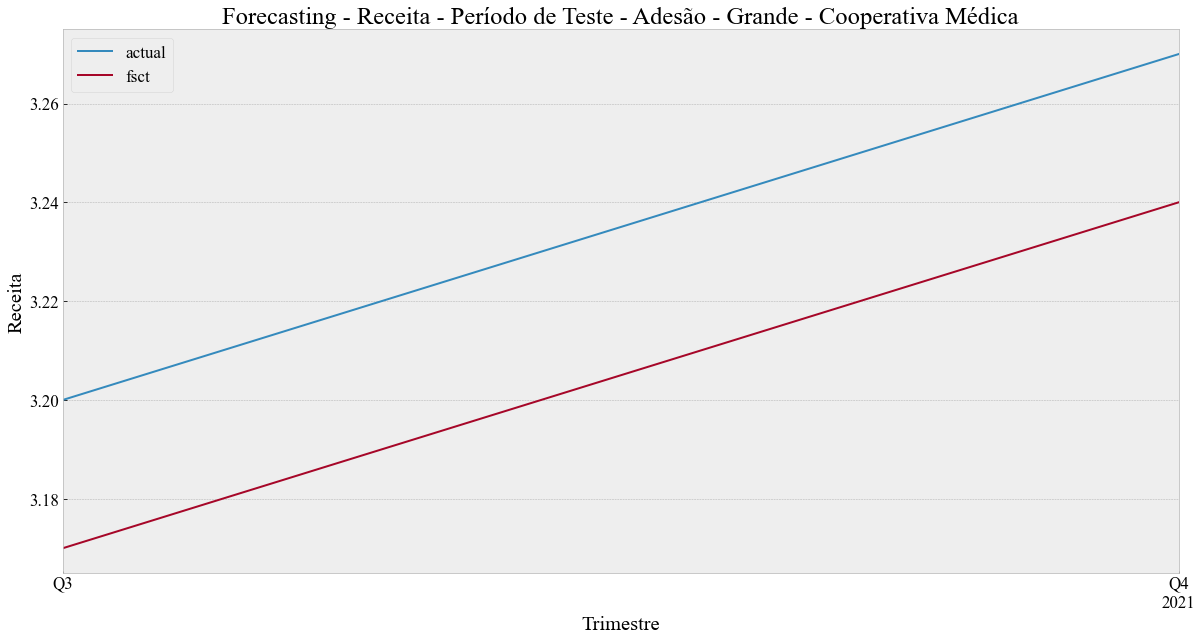

In [172]:
#Plotagem da predição e dados de testes
df_rec_test.plot(figsize=(20,10))
plt.legend(['actual','fsct'])
plt.title(f'Forecasting - Receita - Período de Teste - '+ grupo)
plt.ylabel('Receita')
plt.xlabel('Trimestre')
plt.show()

In [173]:
#Retreinando random forest com os dados completos
#Normalização dos dados
scaler_X_rec_train = preprocessing.MinMaxScaler(feature_range = (0,1))
scaler_X_rec_train.fit(X_rec)
X_rec_scaled = scaler_X_rec_train.transform(X_rec)

y_rec_reshaped = y_rec.to_numpy().reshape(-1,1)

scaler_y_rec = preprocessing.MinMaxScaler(feature_range = (0,1))
scaler_y_rec.fit(y_rec_reshaped)
y_rec_scaled = scaler_y_rec.transform(y_rec_reshaped)

In [174]:
xg_regr_rec = XGBRegressor( max_depth=best_params_rec_grid['max_depth'],
                            n_estimators=best_params_rec_grid['n_estimators'],
                            learning_rate = best_params_rec_grid['learning_rate'])

xg_regr_rec.fit(X_rec_scaled,y_rec_scaled)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=1.3024663267584724e-05, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=4, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, ...)

In [175]:
#Criação do dataframe teste para os 3 próximos anos - Cenário economico

receita_diff1_l1_list = [y_rec.iloc[-1]]
receita_diff1_l1_list_temp = [np.nan]*11
receita_diff1_l1_list.extend(receita_diff1_l1_list_temp)

receita_diff2_l1_list = [ans_agrup_rec['receita_diff2'].iloc[-1]]
receita_diff2_l1_list_temp = [np.nan]*11
receita_diff2_l1_list.extend(receita_diff2_l1_list_temp)

ipca_list = [0.032007, 0.02215]
ipca_list_temp = [0.03]*10
ipca_list.extend(ipca_list_temp)

selic_list = [0.000242, 0.000288]
selic_list_temp = [0.0002]*10
selic_list.extend(selic_list_temp)

#Lista de benefm diff estimados na etapa anterior desse código
benefm_diff_list = df_benefm_pred['benefm'].tolist()

dolar_list = np.array([ans_agrup_full['Dolar'].iloc[-1], 5.478567, 4.9849, 5.51, 5.65, 5.545, 5.85, 5.90, 6.05, 6.10, 6.15, 6.30, 6.40])
dolar_diff_list = np.diff(dolar_list)

pnad_list = [0.191, 0.140]
pnad_list_temp = [0.120]*10
pnad_list.extend(pnad_list_temp)


input = {'n_tri': [1,2,3,4, 1,2,3,4, 1,2,3,4],
         'n_tri_l1': [4, 1,2,3,4, 1,2,3,4,1,2,3],         
         'receita_diff_l1':  receita_diff1_l1_list,
         'receita_diff2_l1': receita_diff2_l1_list,
         'benefm_diff': benefm_diff_list,
         'IPCA': ipca_list,
         'Selic': selic_list,
         'Dolar_diff': dolar_diff_list,
         'PNAD_diff': pnad_list,
         'dmy_covid':[1.0]*12,
         'dmy_n_ops': [0.0]*12}

index_df_pred_test = [  '2022Q1',
                        '2022Q2',
                        '2022Q3',
                        '2022Q4',
                        '2023Q1',
                        '2023Q2',
                        '2023Q3',
                        '2023Q4',
                        '2024Q1',
                        '2024Q2',
                        '2024Q3',
                        '2024Q4']

df_rec_pred_test = pd.DataFrame(input, index = index_df_pred_test)

df_rec_pred_test

,n_tri,n_tri_l1,receita_diff_l1,receita_diff2_l1,benefm_diff,IPCA,Selic,Dolar_diff,PNAD_diff,dmy_covid,dmy_n_ops
2022Q1,1,4,0.070000,0.010000,9198.369141,0.032007,0.000242,0.102400,0.191000,1.000000,0.000000
2022Q2,2,1,NaN,NaN,1433.708740,0.022150,0.000288,-0.493667,0.140000,1.000000,0.000000
2022Q3,3,2,NaN,NaN,7434.059570,0.030000,0.000200,0.525100,0.120000,1.000000,0.000000
2022Q4,4,3,NaN,NaN,4010.755371,0.030000,0.000200,0.140000,0.120000,1.000000,0.000000
2023Q1,1,4,NaN,NaN,4566.497559,0.030000,0.000200,-0.105000,0.120000,1.000000,0.000000
2023Q2,2,1,NaN,NaN,4221.722656,0.030000,0.000200,0.305000,0.120000,1.000000,0.000000
2023Q3,3,2,NaN,NaN,3974.568848,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000
2023Q4,4,3,NaN,NaN,4010.755371,0.030000,0.000200,0.150000,0.120000,1.000000,0.000000
2024Q1,1,4,NaN,NaN,4257.908691,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000
2024Q2,2,1,NaN,NaN,4221.722656,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000


In [177]:
for i in range(len(df_rec_pred_test)):
    #X_test = df_pred_test.iloc[i:i+1]
    X_rec_test = df_rec_pred_test.iloc[:i+1]
    X_rec_test_scaled_test = scaler_X_rec_train.transform(X_rec_test)
    
    y_rec_pred = xg_regr_rec.predict(X_rec_test_scaled_test)
    y_rec_pred = scaler_y_rec_train.inverse_transform(y_rec_pred.reshape(-1,1))
    y_rec_pred = y_rec_pred.reshape(-1)

    #print(y_pred)
    #y_pred_list.append(y_pred)

    if i < len(df_rec_pred_test)-1:
        df_rec_pred_test['receita_diff_l1'].iloc[i+1] = y_rec_pred[-1]
        df_rec_pred_test['receita_diff2_l1'].iloc[i+1] = y_rec_pred[-1] - df_rec_pred_test['receita_diff_l1'].iloc[i:i+1]


#Dataframe opós as predições realizadas na célula anterior
display(df_rec_pred_test)

,n_tri,n_tri_l1,receita_diff_l1,receita_diff2_l1,benefm_diff,IPCA,Selic,Dolar_diff,PNAD_diff,dmy_covid,dmy_n_ops
2022Q1,1,4,0.070000,0.010000,9198.369141,0.032007,0.000242,0.102400,0.191000,1.000000,0.000000
2022Q2,2,1,0.070000,0.000000,1433.708740,0.022150,0.000288,-0.493667,0.140000,1.000000,0.000000
2022Q3,3,2,0.069998,-0.000002,7434.059570,0.030000,0.000200,0.525100,0.120000,1.000000,0.000000
2022Q4,4,3,0.070000,0.000002,4010.755371,0.030000,0.000200,0.140000,0.120000,1.000000,0.000000
2023Q1,1,4,0.070000,0.000000,4566.497559,0.030000,0.000200,-0.105000,0.120000,1.000000,0.000000
2023Q2,2,1,0.070000,0.000000,4221.722656,0.030000,0.000200,0.305000,0.120000,1.000000,0.000000
2023Q3,3,2,0.069998,-0.000002,3974.568848,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000
2023Q4,4,3,0.070000,0.000002,4010.755371,0.030000,0.000200,0.150000,0.120000,1.000000,0.000000
2024Q1,1,4,0.070000,0.000000,4257.908691,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000
2024Q2,2,1,0.070000,0.000000,4221.722656,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000


In [179]:
#Predição para benefm_diff para os próximos 3 anos
df_rec_diff_pred = pd.DataFrame(y_rec_pred, columns=['receita_diff_pred'], index = index_df_pred_test)
df_rec_diff_pred

,receita_diff_pred
2022Q1,0.070000
2022Q2,0.069998
2022Q3,0.070000
2022Q4,0.070000
2023Q1,0.070000
2023Q2,0.069998
2023Q3,0.070000
2023Q4,0.070000
2024Q1,0.070000
2024Q2,0.069998


In [181]:
actual_df_rec = pd.DataFrame(ans_agrup_rec['receita'])

df_rec_pred = df_rec_diff_pred.rename({'receita_diff_pred': 'receita'}, axis = 1)

pred_res_rec = inverse_diff(actual_df_rec,df_rec_pred)

pred_res_rec.rename({'receita_1st_inv_diff': 'receita_pred'}, axis=1, inplace=True)

def_rec_pred = pd.DataFrame(pred_res_rec['receita_pred'])

def_rec_pred

,receita_pred
2022Q1,3.340000
2022Q2,3.409998
2022Q3,3.479998
2022Q4,3.549998
2023Q1,3.619998
2023Q2,3.689996
2023Q3,3.759996
2023Q4,3.829996
2024Q1,3.899996
2024Q2,3.969994


In [182]:
#Criação com os valores reais e estimados pelo modelo
ans_agrup_temp = pd.DataFrame(ans_agrup_full['receita'])
ans_agrup_rec_join = ans_agrup_temp.append(pd.DataFrame(pred_res_rec['receita_pred']))
ans_agrup_rec_join

,receita,receita_pred
2018Q1,2.150000,NaN
2018Q2,2.160000,NaN
2018Q3,2.290000,NaN
2018Q4,2.380000,NaN
2019Q1,2.370000,NaN
2019Q2,2.460000,NaN
2019Q3,2.550000,NaN
2019Q4,2.650000,NaN
2020Q1,2.750000,NaN
2020Q2,2.790000,NaN


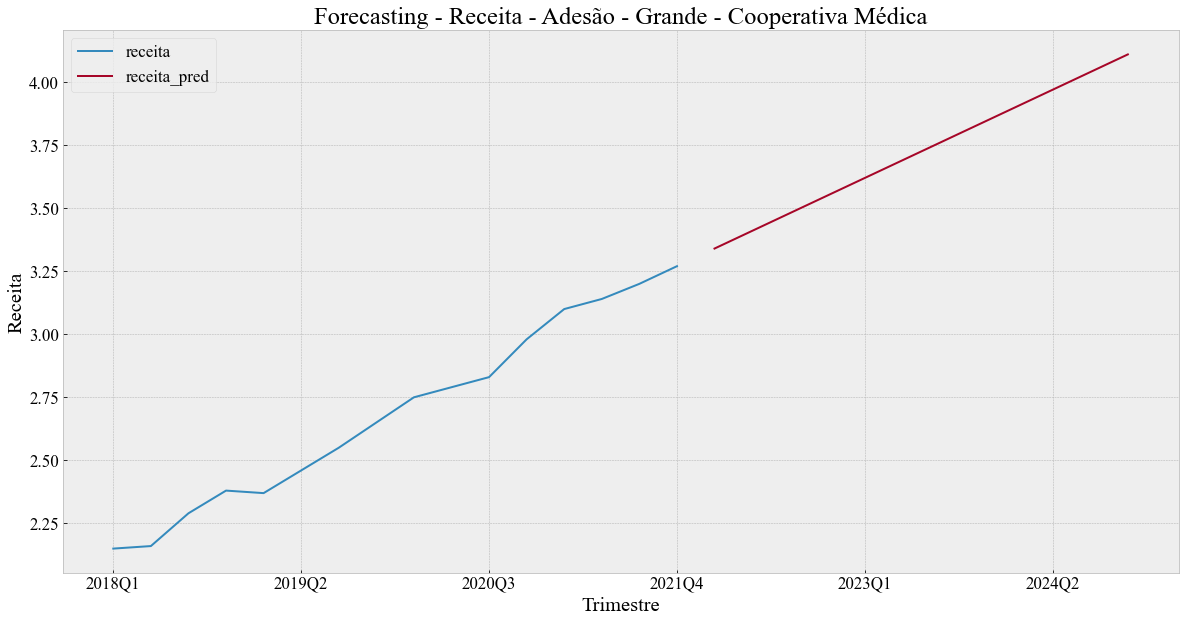

In [183]:
ans_agrup_rec_join.plot(figsize=(20,10))
plt.legend(['receita','receita_pred'])
plt.title(f'Forecasting - Receita - '+ grupo)
plt.ylabel('Receita')
plt.xlabel('Trimestre')
plt.show()

## 3ª Etapa -  Forecasting da Despesa

*Variáveis exógenas*:
01. n_tri - Número do trimestre do ano
02. n_tri_l1 - Número do trimestre do ano com Lag de um período
03. benefm_diff - Primeira Diferença de beneficiario médios estimados na etapa anteriror
04. despesa_diff_l1 - Primeira Diferença da receita com lag de um período
05. despesa_diff2_l1 - Segunda Diferença da receita com lag de um período
06. IPCA - IPCA acumulado para cada trimestre do ano
07. Selic - Taxa Selic acumulada cada trimestre do ano
08. Dolar_diff - Primeira diferenças do dolar medio para cada trimestre da ano
09. PNAD_diff - Primeira diferença do PNAD médio para cada trimestre do ano
10. dmy_covid - Variável dummy para o período de Pandemia
11. dmy_n_ops - Variável dummy para mudança de quantidade de operadoda no segmento

*Variáveis endógena*:
01. despesa_diff - Primeira Diferença das receitas trimestrais

In [184]:
#Criação do dataframe com as variáveis a serem utilizadas no forecasting das despesas trimestrais

ans_agrup_desp = ans_agrup_full[['n_tri','n_tri_l1','despesa','despesa_diff','despesa_diff2','despesa_diff_l1','despesa_diff2_l1',
                                'benefm_diff','IPCA','Selic','Dolar','Dolar_diff','PNAD','PNAD_diff','dmy_covid','dmy_n_ops']]

ans_agrup_desp = ans_agrup_desp.dropna()

ans_agrup_desp

,n_tri,n_tri_l1,despesa,despesa_diff,despesa_diff2,despesa_diff_l1,despesa_diff2_l1,benefm_diff,IPCA,Selic,Dolar,Dolar_diff,PNAD,PNAD_diff,dmy_covid,dmy_n_ops
trimestre,,,,,,,,,,,,,,,,
2018Q4,4.000000,3.000000,1.250000,-0.600000,-0.810000,0.210000,0.150000,4895.666667,0.003894,0.000152,3.904500,0.050600,4424.000000,95.000000,1.000000,0.000000
2019Q1,1.000000,4.000000,1.870000,0.620000,1.220000,-0.600000,-0.810000,2407.666667,0.015070,0.000150,3.776467,-0.128033,4419.000000,-5.000000,1.000000,0.000000
2019Q2,2.000000,1.000000,1.980000,0.110000,-0.510000,0.620000,1.220000,9966.000000,0.007108,0.000153,3.903500,0.127033,4327.000000,-92.000000,1.000000,0.000000
2019Q3,3.000000,2.000000,1.950000,-0.030000,-0.140000,0.110000,-0.510000,1009.666667,0.002601,0.000153,3.882133,-0.021367,4286.000000,-41.000000,1.000000,0.000000
2019Q4,4.000000,3.000000,2.080000,0.130000,0.160000,-0.030000,-0.140000,7990.666667,0.017675,0.000123,4.131167,0.249034,4410.000000,124.000000,1.000000,0.000000
2020Q1,1.000000,4.000000,2.100000,0.020000,-0.110000,0.130000,0.160000,39636.333333,0.005308,0.000101,4.191133,0.059966,4355.000000,-55.000000,0.000000,1.000000
2020Q2,2.000000,1.000000,1.750000,-0.350000,-0.370000,0.020000,-0.110000,5367.666667,-0.004306,0.000073,5.272333,1.081200,4009.000000,-346.000000,0.000000,0.000000
2020Q3,3.000000,2.000000,2.150000,0.400000,0.750000,-0.350000,-0.370000,8234.000000,0.012447,0.000051,5.307533,0.035200,3837.000000,-172.000000,0.000000,0.000000
2020Q4,4.000000,3.000000,2.460000,0.310000,-0.090000,0.400000,0.750000,9007.000000,0.031314,0.000047,5.458467,0.150934,3841.000000,4.000000,1.000000,0.000000


In [185]:
#Criação dos objetos X and y 
#Variáveis Exógenas
X_desp = ans_agrup_desp[['n_tri','n_tri_l1','despesa_diff_l1','despesa_diff2_l1','benefm_diff','IPCA','Selic','Dolar_diff','PNAD_diff','dmy_covid','dmy_n_ops']]

#Variável Endógena
y_desp = ans_agrup_desp['despesa_diff']

#Verificação da estacionariedade da despesa
print('########################################################')
print('Teste Estacionaridade - Despesa_diff')
print('########################################################')
Augmented_Dickey_Fuller_Test_func(y_desp, 'despesa_diff')

########################################################
Teste Estacionaridade - Despesa_diff
########################################################
Results of Dickey-Fuller Test for column despesa_diff
Test Statistic                 -2.139302
p-value                         0.229007
No Lags Used                    4.000000
Number of Observartions Used    8.000000
Critical Value (1%)            -4.665186
Critical Value (5%)            -3.367187
Critical Value (10%)           -2.802961
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


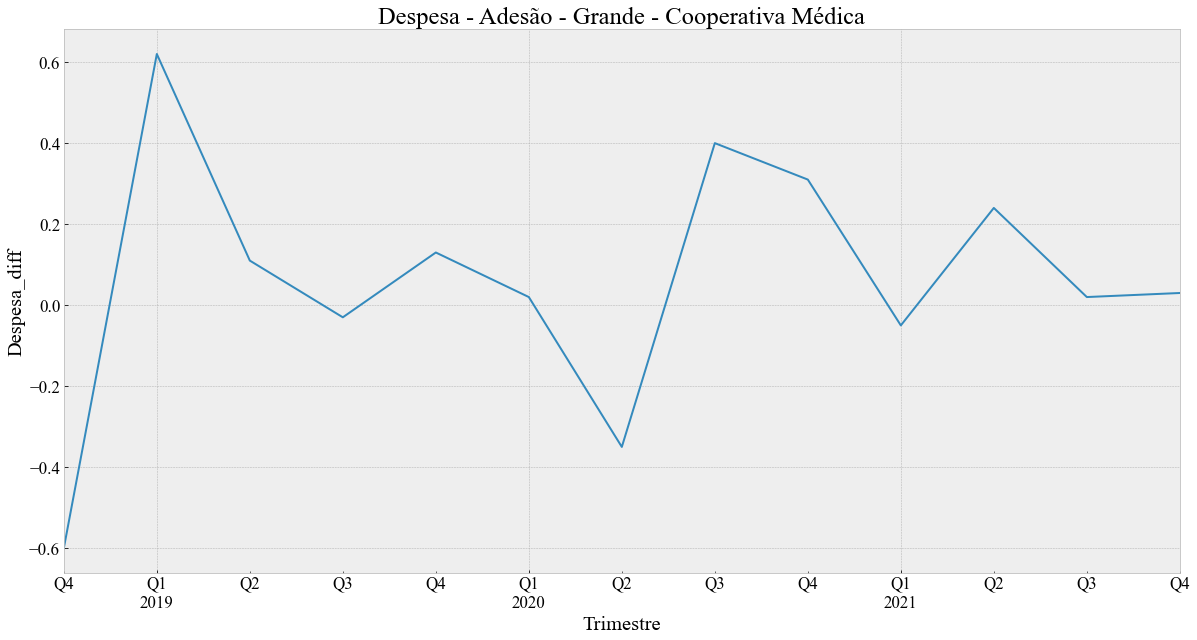

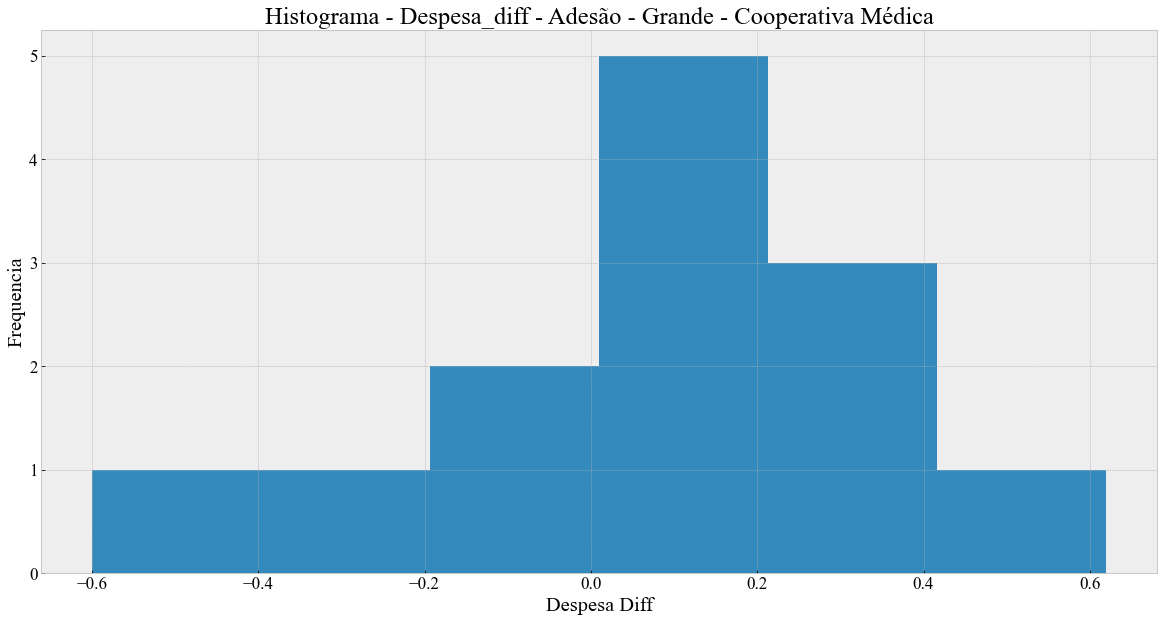

In [187]:
y_desp.plot(y = 'Despesa', figsize=(20,10))
plt.xlabel('Trimestre')
plt.ylabel('Despesa_diff')
plt.title(f'Despesa - '+ grupo)
plt.show()

y_desp.hist(bins='auto',figsize=(20,10))
plt.xlabel('Despesa Diff')
plt.ylabel('Frequencia')
plt.title(f'Histograma - Despesa_diff - ' + grupo)
plt.show()

In [188]:
# Criação dos dataframes com dados de treino e test
#Deixou para o Dataframe de teste os dois últimos trimestre do ano de 2021
X_desp_train, X_desp_test, y_desp_train, y_desp_test = train_test_split(X_desp,y_desp, test_size=2, random_state=1234, shuffle=False)

#Normalização dos dados - Todos os dados foram transformados no intervalo de 0 e 1 para o treinamento e ajustes do forecast 
scaler_X_desp_train = preprocessing.MinMaxScaler(feature_range = (0,1))
scaler_X_desp_train.fit(X_desp_train)
X_desp_train_scaled = scaler_X_desp_train.transform(X_desp_train)

y_desp_train_reshaped = y_desp_train.to_numpy().reshape(-1,1)

scaler_y_desp_train = preprocessing.MinMaxScaler(feature_range = (0,1))
scaler_y_desp_train.fit(y_desp_train_reshaped)
y_desp_train_scaled = scaler_y_desp_train.transform(y_desp_train_reshaped)

In [189]:
#Inicio do treino
#Para encontrar os melhores hiper parametros para o treinamento do Xgbosot regressor, utilizou se BayesSearchCV como método de busca otimizada
xg_regr_desp_bayes = BayesSearchCV( XGBRegressor(),
                                   {'learning_rate': (10e-6, 1.0,'log-uniform'),
                                   'n_estimators': (10,1000,'log-uniform'),
                                   'max_depth': Integer(0, 50,'uniform')},
                                    n_iter=10,                                    
                                    n_jobs=-1,
                                    verbose=True)

xg_regr_desp_bayes.fit(X_desp_train_scaled,y_desp_train_scaled)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


BayesSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     r

In [190]:
X_desp_test_scaled = scaler_X_desp_train.transform(X_desp_test)

y_desp_pred = xg_regr_desp_bayes.predict(X_desp_test_scaled)
y_desp_pred = scaler_y_desp_train.inverse_transform(y_desp_pred.reshape(-1,1))
y_desp_pred = y_desp_pred.reshape(-1)

best_params_desp_bayes = xg_regr_desp_bayes.best_params_

print('Best Hyper parameters')
print(best_params_desp_bayes)

Best Hyper parameters
OrderedDict([('learning_rate', 0.010010622078696088), ('max_depth', 36), ('n_estimators', 48)])


In [191]:
print('########################################################')
print('Métricas do erro - despesa_diff -  Para o dados de Teste')
print('########################################################')
timeseries_evaluation_metrics_func(list(y_desp_test),list(y_desp_pred))

########################################################
Métricas do erro - despesa_diff -  Para o dados de Teste
########################################################
Mean_Squared_Error_(MSE) is : 0.0006868590971826009
Root_Mean_Squared_Error_(RMSE) is : 0.02620799681743343
Mean_Absolute_Error_(MAE) is : 0.02572662234306322
Mean_Absolute_Percentage_Error (MAPE) is : 1.1136092642942983
Symmetrical_Mean_Absolute_Percentage_Error (sMAPE) is : 0.6911928688148676
Coefficient of determination R^2 is : -26.47436388730277



,metrics,scores
0,MSE,0.000687
1,RMSE,0.026208
2,MAE,0.025727
3,MAPE,1.113609
4,sMAPE,0.691193
5,R^2,-26.474364


In [192]:
#Criação do dataframe com "importances" de cada variável exógena
fi_desp = pd.DataFrame( {'features': X_desp_train.columns,
                    'importance': xg_regr_desp_bayes.best_estimator_.feature_importances_})

fi_desp = fi_desp.sort_values('importance', ascending=False)

fi_desp

,features,importance
5,IPCA,0.790710
3,despesa_diff2_l1,0.087391
2,despesa_diff_l1,0.067784
0,n_tri,0.053852
6,Selic,0.000262
1,n_tri_l1,0.000000
4,benefm_diff,0.000000
7,Dolar_diff,0.000000
8,PNAD_diff,0.000000
9,dmy_covid,0.000000


In [193]:
#Valores estimados de receita_diff para o período de treino
df_desp_diff_pred = pd.DataFrame(y_desp_pred, columns=['despesa_diff'])
df_desp_diff_pred

,despesa_diff
0,0.050727
1,0.050727


In [194]:
actual_desp_df = pd.DataFrame(ans_agrup_desp['despesa'].iloc[:-2])

display(actual_desp_df)

df_desp_pred = df_desp_diff_pred.rename({'despesa_diff': 'despesa'}, axis = 1)

res_desp = inverse_diff(actual_desp_df,df_desp_pred)

res_desp = res_desp.rename({'despesa': 'despesa_diff'}, axis = 1)

res_desp

,despesa
trimestre,
2018Q4,1.250000
2019Q1,1.870000
2019Q2,1.980000
2019Q3,1.950000
2019Q4,2.080000
2020Q1,2.100000
2020Q2,1.750000
2020Q3,2.150000
2020Q4,2.460000


,despesa_diff,despesa_1st_inv_diff
0,0.050727,2.700727
1,0.050727,2.751453


In [197]:
print('########################################################')
print('Métricas do erro - despesa -  Para o dados de Teste')
print('########################################################')
df_evaluation_metrics_desp = timeseries_evaluation_metrics_func(list(ans_agrup['despesa'].iloc[-2:]),list(res_desp['despesa_1st_inv_diff']))

df_evaluation_metrics_desp.to_csv('xgboost_errors_metrics_desp_bayes_'+ grupo +'.csv',  sep=';', index=False, encoding='mbcs', decimal=',')

########################################################
Métricas do erro - despesa -  Para o dados de Teste
########################################################
Mean_Squared_Error_(MSE) is : 0.0017957926745515965
Root_Mean_Squared_Error_(RMSE) is : 0.042376794057026025
Mean_Absolute_Error_(MAE) is : 0.0410900735855102
Mean_Absolute_Percentage_Error (MAPE) is : 0.015282479912054999
Symmetrical_Mean_Absolute_Percentage_Error (sMAPE) is : 0.01515962636226156
Coefficient of determination R^2 is : -6.9813007757847405



In [199]:
df_desp_test = pd.DataFrame(ans_agrup['despesa'].iloc[-2:])

df_desp_test['despesa_pred'] = res_desp['despesa_1st_inv_diff'].to_numpy()

df_desp_test

,despesa,despesa_pred
trimestre,,
2021Q3,2.670000,2.700727
2021Q4,2.700000,2.751453


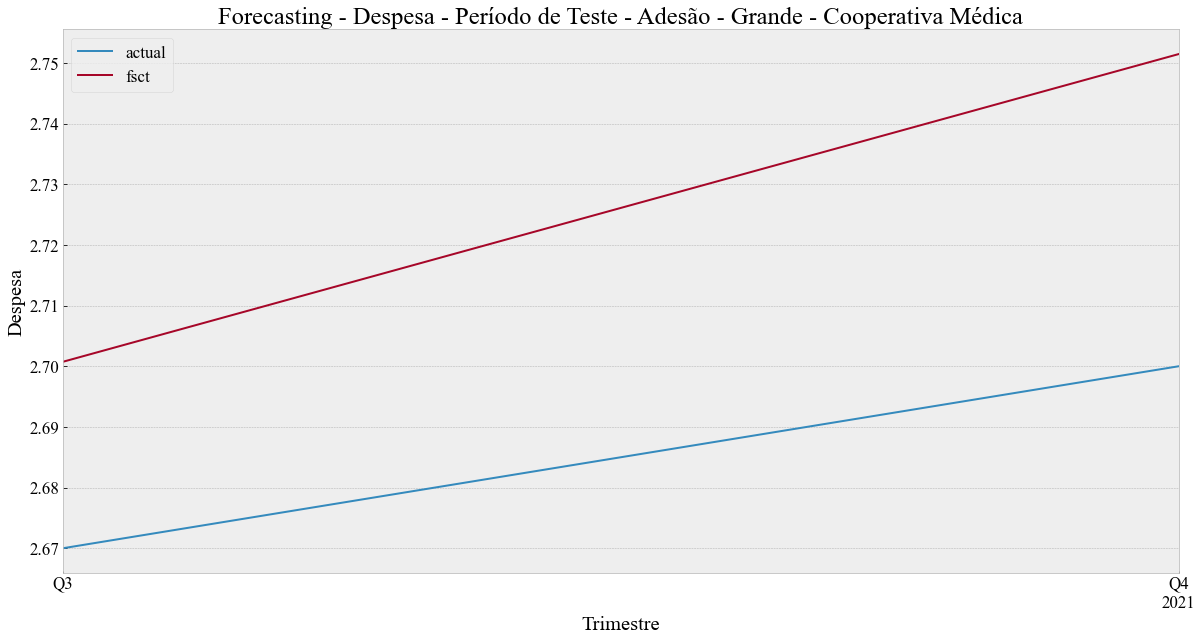

In [200]:
df_desp_test.plot(figsize=(20,10))
plt.legend(['actual','fsct'])
plt.title(f'Forecasting - Despesa - Período de Teste - '+ grupo)
plt.ylabel('Despesa')
plt.xlabel('Trimestre')
plt.show()

In [201]:
#Retreinando random forest com os dados completos
#Normalização dos dados
scaler_X_desp = preprocessing.MinMaxScaler(feature_range = (0,1))
scaler_X_desp.fit(X_desp)
X_desp_scaled = scaler_X_desp.transform(X_desp)

y_desp_reshaped = y_desp.to_numpy().reshape(-1,1)

scaler_y_desp = preprocessing.MinMaxScaler(feature_range = (0,1))
scaler_y_desp.fit(y_desp_reshaped)
y_desp_scaled = scaler_y_desp.transform(y_desp_reshaped)

In [202]:
xg_regr_desp = XGBRegressor( max_depth=best_params_desp_bayes['max_depth'],
                            n_estimators=best_params_desp_bayes['n_estimators'],
                            learning_rate = best_params_desp_bayes['learning_rate'])

xg_regr_desp.fit(X_desp_scaled,y_desp_scaled)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.010010622078696088, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=36, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=48, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, ...)

In [203]:
#Criação do dataframe teste para os 3 próximos anos - Cenário economico
despesa_diff1_l1_list = [y_desp.iloc[-1]]
despesa_diff1_l1_list_temp = [np.nan]*11
despesa_diff1_l1_list.extend(despesa_diff1_l1_list_temp)

despesa_diff2_l1_list = [ans_agrup_desp['despesa_diff2'].iloc[-1]]
despesa_diff2_l1_list_temp = [np.nan]*11
despesa_diff2_l1_list.extend(despesa_diff2_l1_list_temp)

ipca_list = [0.032007, 0.02215]
ipca_list_temp = [0.03]*10
ipca_list.extend(ipca_list_temp)

selic_list = [0.000242, 0.000288]
selic_list_temp = [0.0002]*10
selic_list.extend(selic_list_temp)

benefm_diff_list = df_benefm_pred['benefm'].tolist()

dolar_list = np.array([ans_agrup_full['Dolar'].iloc[-1], 5.478567, 4.9849, 5.51, 5.65, 5.545, 5.85, 5.90, 6.05, 6.10, 6.15, 6.30, 6.40])
dolar_diff_list = np.diff(dolar_list)

pnad_list = [0.191, 0.140]
pnad_list_temp = [0.120]*10
pnad_list.extend(pnad_list_temp)

#X_desp = ans_agrup_desp[['n_tri','n_tri_l1','despesa_diff_l1','despesa_diff2_l1','benefm_diff','IPCA','Selic','Dolar_diff','PNAD_diff','dmy_covid','dmy_n_ops']]

input = {'n_tri': [1,2,3,4, 1,2,3,4, 1,2,3,4],
         'n_tri_l1': [4, 1,2,3,4, 1,2,3,4,1,2,3],         
         'despesa_diff_l1':  despesa_diff1_l1_list,
         'despesa_diff2_l1': despesa_diff2_l1_list,
         'benefm_diff': benefm_diff_list,
         'IPCA': ipca_list,
         'Selic': selic_list,
         'Dolar_diff': dolar_diff_list,
         'PNAD_diff': pnad_list,
         'dmy_covid':[1.0]*12,
         'dmy_n_ops': [0.0]*12}

index_df_pred_test = [  '2022Q1',
                        '2022Q2',
                        '2022Q3',
                        '2022Q4',
                        '2023Q1',
                        '2023Q2',
                        '2023Q3',
                        '2023Q4',
                        '2024Q1',
                        '2024Q2',
                        '2024Q3',
                        '2024Q4']

df_desp_pred_test = pd.DataFrame(input, index = index_df_pred_test)

#Dataframe com os valores para predição dos próximos anos
df_desp_pred_test

,n_tri,n_tri_l1,despesa_diff_l1,despesa_diff2_l1,benefm_diff,IPCA,Selic,Dolar_diff,PNAD_diff,dmy_covid,dmy_n_ops
2022Q1,1,4,0.030000,0.010000,9198.369141,0.032007,0.000242,0.102400,0.191000,1.000000,0.000000
2022Q2,2,1,NaN,NaN,1433.708740,0.022150,0.000288,-0.493667,0.140000,1.000000,0.000000
2022Q3,3,2,NaN,NaN,7434.059570,0.030000,0.000200,0.525100,0.120000,1.000000,0.000000
2022Q4,4,3,NaN,NaN,4010.755371,0.030000,0.000200,0.140000,0.120000,1.000000,0.000000
2023Q1,1,4,NaN,NaN,4566.497559,0.030000,0.000200,-0.105000,0.120000,1.000000,0.000000
2023Q2,2,1,NaN,NaN,4221.722656,0.030000,0.000200,0.305000,0.120000,1.000000,0.000000
2023Q3,3,2,NaN,NaN,3974.568848,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000
2023Q4,4,3,NaN,NaN,4010.755371,0.030000,0.000200,0.150000,0.120000,1.000000,0.000000
2024Q1,1,4,NaN,NaN,4257.908691,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000
2024Q2,2,1,NaN,NaN,4221.722656,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000


In [204]:
for i in range(len(df_desp_pred_test)):
    #X_test = df_pred_test.iloc[i:i+1]
    X_desp_test = df_desp_pred_test.iloc[:i+1]
    X_desp_test_scaled = scaler_X_desp.transform(X_desp_test)
        
    y_desp_pred = xg_regr_desp.predict(X_desp_test_scaled)
    y_desp_pred = scaler_y_desp.inverse_transform(y_desp_pred.reshape(-1,1))
    y_desp_pred = y_desp_pred.reshape(-1)


    if i < len(df_desp_pred_test)-1:
        df_desp_pred_test['despesa_diff_l1'].iloc[i+1] = y_desp_pred[-1]
        df_desp_pred_test['despesa_diff2_l1'].iloc[i+1] = y_rec_pred[-1] - df_desp_pred_test['despesa_diff_l1'].iloc[i:i+1]

display(df_desp_pred_test)

,n_tri,n_tri_l1,despesa_diff_l1,despesa_diff2_l1,benefm_diff,IPCA,Selic,Dolar_diff,PNAD_diff,dmy_covid,dmy_n_ops
2022Q1,1,4,0.030000,0.010000,9198.369141,0.032007,0.000242,0.102400,0.191000,1.000000,0.000000
2022Q2,2,1,0.048800,0.040000,1433.708740,0.022150,0.000288,-0.493667,0.140000,1.000000,0.000000
2022Q3,3,2,0.012749,0.021200,7434.059570,0.030000,0.000200,0.525100,0.120000,1.000000,0.000000
2022Q4,4,3,0.046926,0.057251,4010.755371,0.030000,0.000200,0.140000,0.120000,1.000000,0.000000
2023Q1,1,4,0.046926,0.023074,4566.497559,0.030000,0.000200,-0.105000,0.120000,1.000000,0.000000
2023Q2,2,1,0.012749,0.023074,4221.722656,0.030000,0.000200,0.305000,0.120000,1.000000,0.000000
2023Q3,3,2,0.048800,0.057251,3974.568848,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000
2023Q4,4,3,0.012749,0.021200,4010.755371,0.030000,0.000200,0.150000,0.120000,1.000000,0.000000
2024Q1,1,4,0.046926,0.057251,4257.908691,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000
2024Q2,2,1,0.012749,0.023074,4221.722656,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000


In [207]:
#Predição para despesa_diff para os próximos 3 anos
df_desp_diff_pred = pd.DataFrame(y_desp_pred, columns=['despesa_diff_pred'], index = index_df_pred_test)
df_desp_diff_pred

,despesa_diff_pred
2022Q1,0.048800
2022Q2,0.012749
2022Q3,0.046926
2022Q4,0.046926
2023Q1,0.012749
2023Q2,0.048800
2023Q3,0.012749
2023Q4,0.046926
2024Q1,0.012749
2024Q2,0.012749


In [209]:
actual_desp_df = pd.DataFrame(ans_agrup_desp['despesa'])

df_desp_pred = df_desp_diff_pred.rename({'despesa_diff_pred': 'despesa'}, axis = 1)

pred_res_desp = inverse_diff(actual_desp_df,df_desp_pred)

pred_res_desp.rename({'despesa_1st_inv_diff': 'despesa_pred'}, axis=1, inplace=True)

def_desp_pred = pd.DataFrame(pred_res_desp['despesa_pred'])

def_desp_pred

,despesa_pred
2022Q1,2.748800
2022Q2,2.761549
2022Q3,2.808474
2022Q4,2.855400
2023Q1,2.868149
2023Q2,2.916949
2023Q3,2.929698
2023Q4,2.976623
2024Q1,2.989372
2024Q2,3.002121


In [210]:
#Criação com os valores reais e estimados pelo modelo
ans_agrup_temp = pd.DataFrame(ans_agrup_full['despesa'])
ans_agrup_desp_join = ans_agrup_temp.append(pd.DataFrame(pred_res_desp['despesa_pred']))
ans_agrup_desp_join

,despesa,despesa_pred
2018Q1,1.580000,NaN
2018Q2,1.640000,NaN
2018Q3,1.850000,NaN
2018Q4,1.250000,NaN
2019Q1,1.870000,NaN
2019Q2,1.980000,NaN
2019Q3,1.950000,NaN
2019Q4,2.080000,NaN
2020Q1,2.100000,NaN
2020Q2,1.750000,NaN


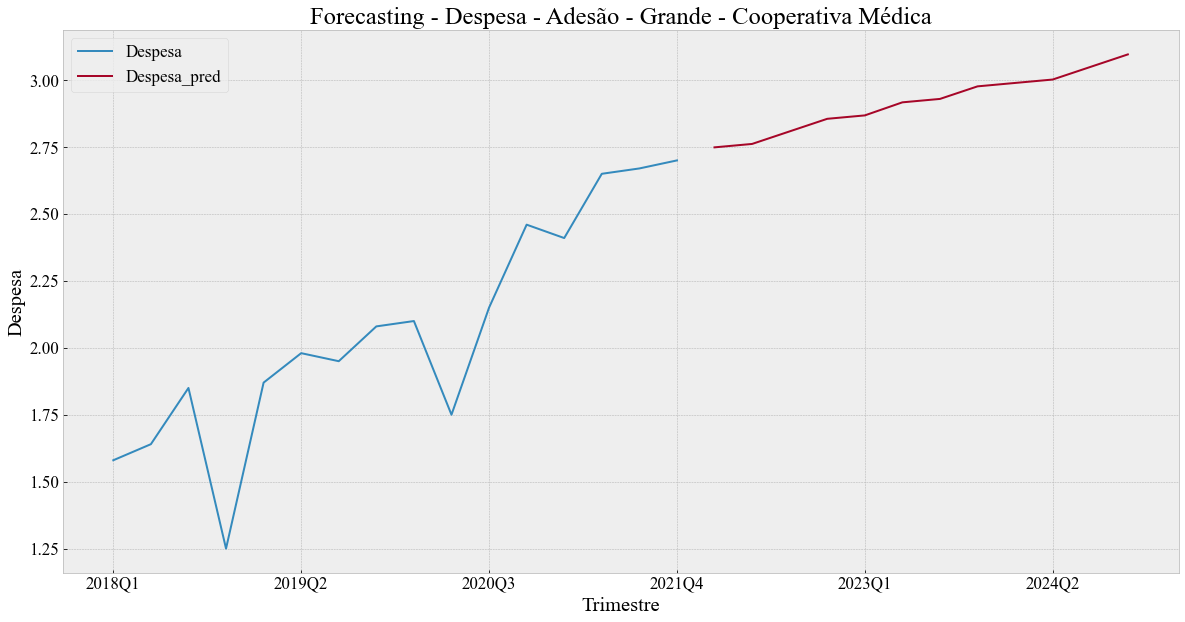

In [211]:
ans_agrup_desp_join.plot(figsize=(20,10))
plt.legend(['Despesa','Despesa_pred'])
plt.title(f'Forecasting - Despesa - '+ grupo)
plt.ylabel('Despesa')
plt.xlabel('Trimestre')
plt.show()

### Reunião de todas bases com as predições realizadas em cada etapa

In [213]:
ans_agrup_pred_temp = ans_agrup_rec_join.join(ans_agrup_desp_join)

ans_agrup_pred = ans_agrup_pred_temp.join(ans_agrup_benefm_join)

ans_agrup_pred = ans_agrup_pred.reset_index()

ans_agrup_pred.rename({'index':'trimestre'}, axis=1, inplace=True)

#Cálculo do ticket Médio
ans_agrup_pred['avg_ticket'] = np.where((ans_agrup_pred.index <= 15), ((ans_agrup_pred['receita']*(1e9)/3.0)/ans_agrup_pred['benefm']),
                                                                      ((ans_agrup_pred['receita_pred']*(1e9)/3.0)/ans_agrup_pred['benefm_pred']))

#Cálculo do Indice de Sinistralidade
ans_agrup_pred['ind_sinistralidade'] = np.where((ans_agrup_pred.index <= 15), (ans_agrup_pred['despesa']/ans_agrup_pred['receita'])*100,
                                                                              (ans_agrup_pred['despesa_pred']/ans_agrup_pred['receita_pred'])*100)

ans_agrup_pred['trimestre'] = pd.PeriodIndex(ans_agrup_pred['trimestre'], freq="Q")

ans_agrup_pred.to_csv('xgboost_bayes_results_'+ grupo +'.csv',  sep=';', index=False, encoding='mbcs', decimal=',')

ans_agrup_pred.set_index('trimestre', inplace=True)

ans_agrup_pred.info()

ans_agrup_pred

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 28 entries, 2018Q1 to 2024Q4
Freq: Q-DEC
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   receita             16 non-null     float64
 1   receita_pred        12 non-null     float32
 2   despesa             16 non-null     float64
 3   despesa_pred        12 non-null     float32
 4   benefm              16 non-null     float64
 5   benefm_pred         12 non-null     float32
 6   avg_ticket          28 non-null     float64
 7   ind_sinistralidade  28 non-null     float64
dtypes: float32(3), float64(5)
memory usage: 1.6 KB


,receita,receita_pred,despesa,despesa_pred,benefm,benefm_pred,avg_ticket,ind_sinistralidade
trimestre,,,,,,,,
2018Q1,2.150000,NaN,1.580000,NaN,551754.666667,NaN,1298.886462,73.488372
2018Q2,2.160000,NaN,1.640000,NaN,555789.666667,NaN,1295.454096,75.925926
2018Q3,2.290000,NaN,1.850000,NaN,559564.000000,NaN,1364.157332,80.786026
2018Q4,2.380000,NaN,1.250000,NaN,564459.666667,NaN,1405.473907,52.521008
2019Q1,2.370000,NaN,1.870000,NaN,566867.333333,NaN,1393.624140,78.902954
2019Q2,2.460000,NaN,1.980000,NaN,576833.333333,NaN,1421.554464,80.487805
2019Q3,2.550000,NaN,1.950000,NaN,577843.000000,NaN,1470.987794,76.470588
2019Q4,2.650000,NaN,2.080000,NaN,585833.666667,NaN,1507.822755,78.490566
2020Q1,2.750000,NaN,2.100000,NaN,625470.000000,NaN,1465.564562,76.363636


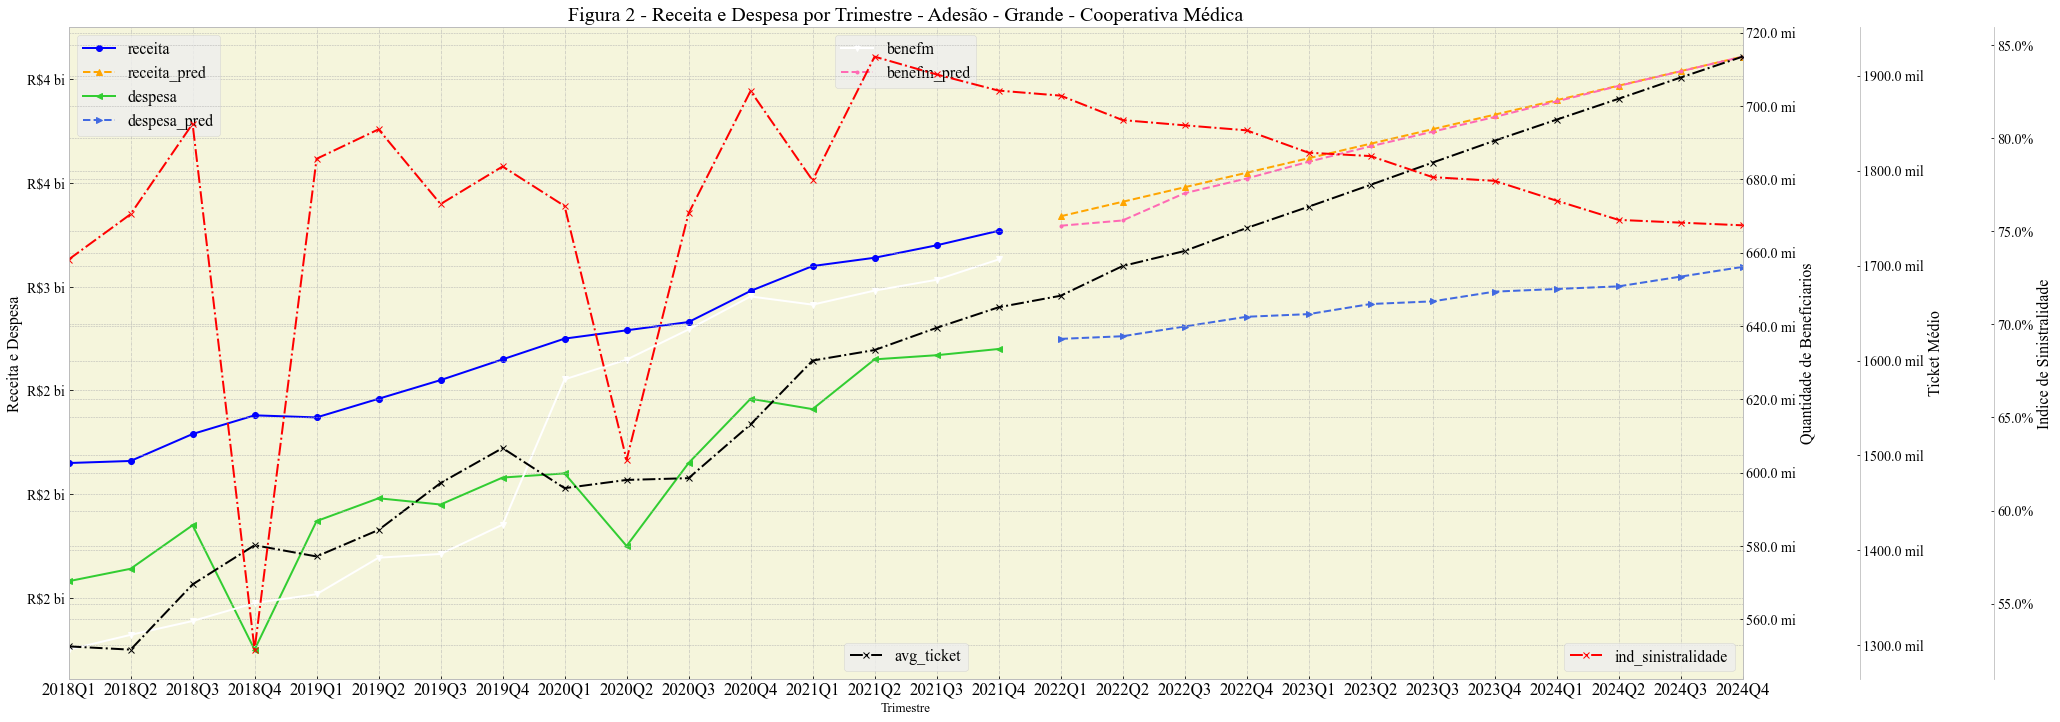

In [214]:
df_plot = ans_agrup_pred.copy()

#df_plot.set_index('trimestre', inplace=True)

fig,ax1 = plt.subplots()

df_plot.plot(y=['receita','receita_pred','despesa','despesa_pred'],figsize=(30, 12), color=['blue','orange','limegreen','royalblue'], style=['o-','^--','<-','>--'], ax=ax1)
ax1.set_title('Figura 2 - Receita e Despesa por Trimestre - ' + grupo, fontsize = 20)
ax1.set_xticks(df_plot.index)
ax1.set_xticklabels(df_plot.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita e Despesa', fontsize=16)
ax1.legend(loc = 'upper left', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_plot.plot(y=['benefm', 'benefm_pred'], color=['w','hotpink'],style=['v-','.--'], ax=ax2)
ax2.set_xticks(df_plot.index)
ax2.set_xticklabels(df_plot.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
yticks = ax2.get_yticks()
ax2.set_yticklabels(['{:.1f} mi'.format(x/1e3) for x in yticks], fontsize = 14)
ax2.set_ylabel('Quantidade de Beneficiarios', fontsize=16)
ax2.legend(loc = 'upper center', fontsize = 16)

ax3 = ax1.twinx()

ax3.spines.right.set_position(("axes", 1.07))

df_plot.plot(y=['avg_ticket'], style=['kx-.'], ax=ax3)
ax3.set_xticks(df_plot.index)
ax3.set_xticklabels(df_plot.index)
ax3.set_xlabel('Trimestre', fontsize = 13)
yticks = ax3.get_yticks()
ax3.set_yticklabels(['{:.1f} mil'.format(x) for x in yticks], fontsize = 14)
ax3.set_ylabel('Ticket Médio', fontsize=16)
ax3.legend(loc = 'lower center', fontsize = 16)

ax4 = ax1.twinx()

ax4.spines.right.set_position(("axes", 1.15))

df_plot.plot(y=['ind_sinistralidade'], color=['red'], style=['x-.'], ax=ax4)
ax4.set_xticks(df_plot.index)
ax4.set_xticklabels(df_plot.index)
ax4.set_xlabel('Trimestre', fontsize = 13)
yticks = ax4.get_yticks()
ax4.set_yticklabels(['{:.1f}%'.format(x) for x in yticks], fontsize = 14)
ax4.set_ylabel('Indice de Sinistralidade', fontsize=16)
ax4.legend(loc = 'lower right', fontsize = 16)

plt.savefig(grupo + '_xgboost_bayes_pred.png',
            bbox_inches="tight",
            pad_inches=1,
            facecolor='w')

plt.show()

del df_plot